In [1]:
# Import all necessary packages to run functions
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import QuadGate
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
from seaborn import relplot


def importF(pathname):
    """
    Import FCS files. Variable input: name of path name to file. Output is a list of Data File Names in FCT Format
    Title/file names are returned in the array file --> later referenced in other functions as title/titles input argument
    """
    # Declare arrays and int
    file = []
    sample = []
    title = []
    z = 0
    # Read in user input for file path and assign to array file
    pathlist = Path(r"" + str(pathname)).glob("**/*.fcs")
    for path in pathlist:
        path_in_str = str(path)
        file.append(path_in_str)
    file.sort()
    # Go through each file and assign the file contents to entry in the array sample
    for entry in file:
        sample.append(FCMeasurement(ID="Test Sample" + str(z), datafile=entry))
        z += 1
    importF.sample = sample
    # Returns the array sample which contains data of each file in folder (one file per entry in array)
    return sample, file


def sampleT(smpl):
    """Output is the T cells data (the protein channels related to T cells)"""
    # Features are the protein channels of interest when analyzing T cells
    features = ["BL1-H", "VL1-H", "VL4-H", "BL3-H"]
    # Transform to put on log scale
    tform = smpl.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "BL3-H", "RL1-H"])
    # Save the data of each column of the protein channels
    data = tform.data[["BL1-H", "VL1-H", "VL4-H", "BL3-H"]][0:]
    # Save pSTAT5 data
    pstat = tform.data[["RL1-H"]][0:]
    return data, pstat, features


def sampleNK(smpl):
    """Output is the NK cells data (the protein channels related to NK cells)"""
    # For NK, the data consists of different channels so the data var. output will be different
    # Output is data specific to NK cells
    # Features for the NK file of proteins (CD3, CD8, CD56)
    features = ["VL4-H", "RL1-H", "BL1-H"]
    # Transform all proteins (including pSTAT5)
    tform = smpl.transform("hlog", channels=["VL4-H", "RL1-H", "BL1-H", "BL2-H"])
    # Assign data of three protein channels AND pSTAT5
    data = tform.data[["VL4-H", "RL1-H", "BL1-H"]][0:]
    pstat = tform.data[["BL2-H"]][0:]
    return data, pstat, features


def appPCA(data, features):
    """Applies the PCA algorithm to the data set"""
    # Apply PCA to the data set
    # setting values of data of selected features to data frame
    xi = data.loc[:, features].values
    # STANDARDIZE DATA --> very important to do before applying machine learning algorithm
    scaler = preprocessing.StandardScaler()
    xs = scaler.fit_transform(xi)
    #xs = sklearn.preprocessing.scale(xi)
    xs = np.nan_to_num(xs)
    # setting how many components wanted --> PC1 and PC2
    pca = PCA(n_components=2)
    # apply PCA to standardized data set
    # NOTE: score == xf
    xf = pca.fit(xs).transform(xs)
    # creates the loading array (equation is defintion of loading)
    loading = pca.components_.T
    return xf, loading


def pcaPlt(xf, pstat, features, i, title):
    """
    Used to plot the score graph.
    Scattered point color gradients are based on range/abundance of pSTAT5 data. Light --> Dark = Less --> More Active
    """
    # PCA
    if len(features) == 4:
        name = "T Cells"
    elif len(features) == 3:
        name = "NK Cells"
    # Setting x and y values from xf
    x = xf[:, 0]
    y = xf[:, 1]
    pstat_data = pstat.values
    pstat_mean = np.mean(pstat_data)
    print("mean pStat activity: ", pstat_mean)
    # Creating a figure for both scatter and mesh plots for PCA
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel("Principal Component 1", fontsize=15)
    ax.set_ylabel("Principal Component 2", fontsize=15)
    ax.set_title(name + " - PCA - " + str(title), fontsize=20)
    ax.set(xlim=(-5, 5), ylim=(-5, 5))

    # This is the scatter plot of the cell clusters colored by pSTAT5 data
    # lighter --> darker = less --> more pSTAT5 present
    #tips = sns.load_dataset("tips")
    print(x)
    print(y)
    print(np.squeeze(pstat_data))
    pstat = np.squeeze(pstat_data)
    #df1 = pd.DataFrame(x, columns = ["x"])
    #df2 = pd.DataFrame(y, columns = ["y"])
    #df3 = pd.DataFrame(np.squeeze(pstat_data), columns = ["pSTAT5"])
    #combined = pd.concat([df1, df2, df3])
    #df = pd.DataFrame(x,y,np.squeeze(pstat_data), columns = ["x", "y", "pSTAT5"])
    #df = pd.DataFrame(combined, columns = ["x","y", "pSTAT5"])
    #df2 = pd.DataFrame(pstat_data, columns = ["pSTAT5"])
    # print(combined)
    #print(df2)
    
    combined = np.stack((x, y, pstat)).T
    print(combined.T)
    df = pd.DataFrame(combined, columns = ["x","y", "pSTAT5"])
    print(df)
    cmap = sns.palplot(sns.light_palette((210, 90, 60), input="husl"))
    sns.relplot(x="x", y="y", hue = "pSTAT5", data=df);
    
    #plt.scatter(x, y, s=0.1, c=np.squeeze(pstat_data), cmap=sns.light_palette(210, 90, 60))
    # Working with pSTAT5 data

    
def loadingPlot(loading, features, i, title):
    """Plot the loading data"""
    # Loading
    # Create graph for loading values
    x_load = loading[:, 0]
    y_load = loading[:, 1]

    # Create figure for the loading plot
    fig1 = plt.figure(figsize=(8, 8))
    ax = fig1.add_subplot(1, 1, 1)
    ax.set_xlabel("PC1", fontsize=15)
    ax.set_ylabel("PC2", fontsize=15)
    plt.scatter(x_load, y_load)

    for z, feature in enumerate(features):
        # Please note: not the best logic, but there are three features in NK and four features in T cells
        if len(features) == 4:
            name = "T Cells"
            if feature == "BL1-H":
                feature = "Foxp3"
            elif feature == "VL1-H":
                feature = "CD25"
            elif feature == "VL4-H":
                feature = "CD4"
            elif feature == "BL3-H":
                feature = "CD45RA"
        if len(features) == 3:
            name = "NK Cells"
            if feature == "VL4-H":
                feature = "CD3"
            if feature == "RL1-H":
                feature = "CD8"
            if feature == "BL1-H":
                feature = "CD56"
        plt.annotate(str(feature), xy=(x_load[z], y_load[z]))
    ax.set_title(name + " - Loading - " + str(title), fontsize=20)
    
    
def pcaAll(sampleType, check, titles):
    """
    Use to plot the score and loading graphs for PCA. Assign protein and pstat5 arrays AND score and loading arrays
    This is all the data for each file.
    Want to use for both T and NK cells? Use it twice!
    sampleType is importF for T or NK
    check == "t" for T cells OR check == "n" for NK cells
    """
    # declare the arrays to store the data
    data_array = []
    pstat_array = []
    xf_array = []
    loading_array = []
    
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    if check == "t":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleT(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            xf_array.append(xf)
            loading_array.append(loading)
            pcaPlt(xf, pstat, features, i, title)
            loadingPlot(loading, features, i, title)
            plt.show()
    elif check == "n":
        for i, sample in enumerate(sampleType):
            title = titles[i].split("/")
            title = title[len(title)-1]
            data, pstat, features = sampleNK(sample)
            data_array.append(data)
            pstat_array.append(pstat)
            xf, loading = appPCA(data, features)
            pcaPlt(xf, pstat, features, i, title)
            loadingPlot(loading, features, i, title)
            plt.show()
    return data_array, pstat_array, xf_array, loading_array


/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
#/home/heatherm/gating/t418

What is the name of the T plate folder?: /home/heatherm/gating/t418
What is the name of the NK plate folder?: /home/heatherm/gating/t418


mean pStat activity:  5542.181
[ 0.60509455 -0.05568073 -0.26655978 ...  1.016436    1.6295975
  6.629284  ]
[-1.9131762  -0.84346515  1.0204304  ... -0.44999388  1.1148655
  1.0477121 ]
[4963.103  5392.265  4646.8853 ... 3670.9604 6363.4634 4010.2263]
[[ 6.0509455e-01 -5.5680733e-02 -2.6655978e-01 ...  1.0164360e+00
   1.6295975e+00  6.6292839e+00]
 [-1.9131762e+00 -8.4346515e-01  1.0204304e+00 ... -4.4999388e-01
   1.1148655e+00  1.0477121e+00]
 [ 4.9631030e+03  5.3922651e+03  4.6468853e+03 ...  3.6709604e+03
   6.3634634e+03  4.0102263e+03]]
              x         y       pSTAT5
0      0.605095 -1.913176  4963.103027
1     -0.055681 -0.843465  5392.265137
2     -0.266560  1.020430  4646.885254
3     -1.775292  0.724818  4493.825684
4     -1.198438 -0.317537  4816.247559
...         ...       ...          ...
18371  0.162523  1.289912  6148.067383
18372  0.842298 -0.906339  6224.185547
18373  1.016436 -0.449994  3670.960449
18374  1.629598  1.114866  6363.463379
18375  6.629284  1.0

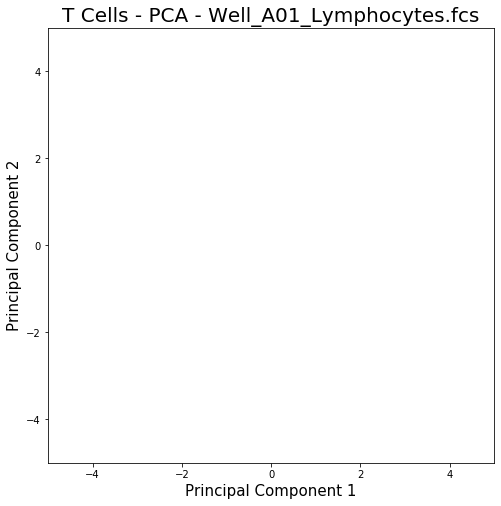

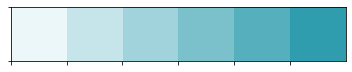

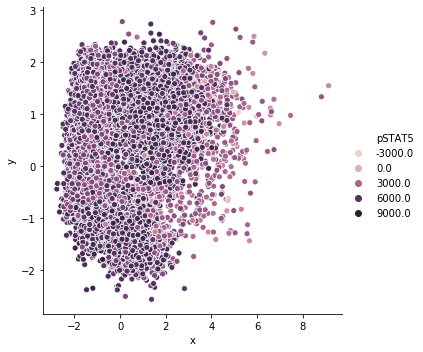

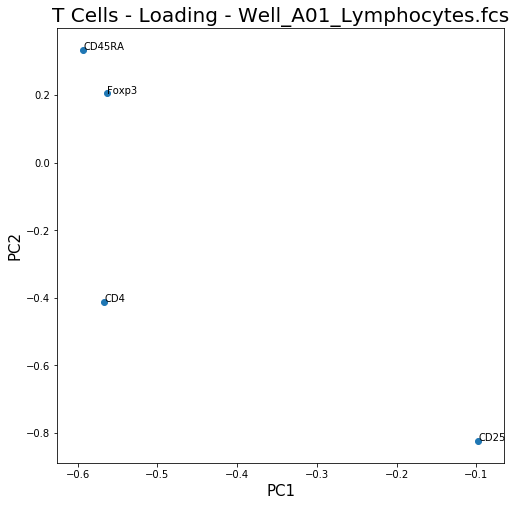

mean pStat activity:  5523.283
[6.4329305 5.796122  2.5922718 ... 5.832177  1.1998506 1.4747603]
[ 1.6154118  0.4936327  1.6413697 ...  1.5052578 -1.6939625 -1.4740684]
[3605.4656 3868.4941 6072.5596 ... 4171.903  4282.25   4030.2673]
[[ 6.4329305e+00  5.7961221e+00  2.5922718e+00 ...  5.8321772e+00
   1.1998506e+00  1.4747603e+00]
 [ 1.6154118e+00  4.9363270e-01  1.6413697e+00 ...  1.5052578e+00
  -1.6939625e+00 -1.4740684e+00]
 [ 3.6054656e+03  3.8684941e+03  6.0725596e+03 ...  4.1719028e+03
   4.2822500e+03  4.0302673e+03]]
              x         y       pSTAT5
0      6.432930  1.615412  3605.465576
1      5.796122  0.493633  3868.494141
2      2.592272  1.641370  6072.559570
3      1.065013  0.867124  6625.553711
4     -0.408520 -1.642518  6305.579590
...         ...       ...          ...
13433 -1.205169  1.642205  4864.912109
13434 -1.471113  0.156411  4445.750488
13435  5.832177  1.505258  4171.902832
13436  1.199851 -1.693962  4282.250000
13437  1.474760 -1.474068  4030.267334

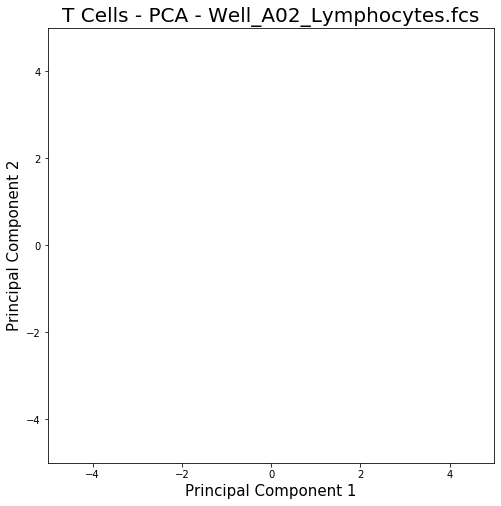

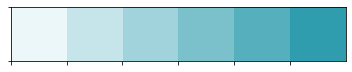

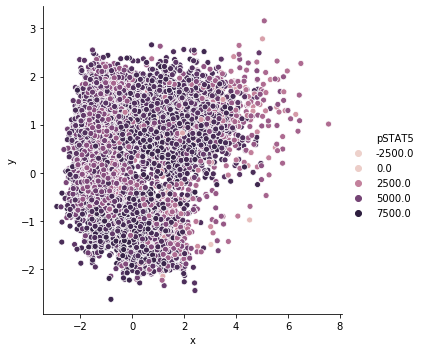

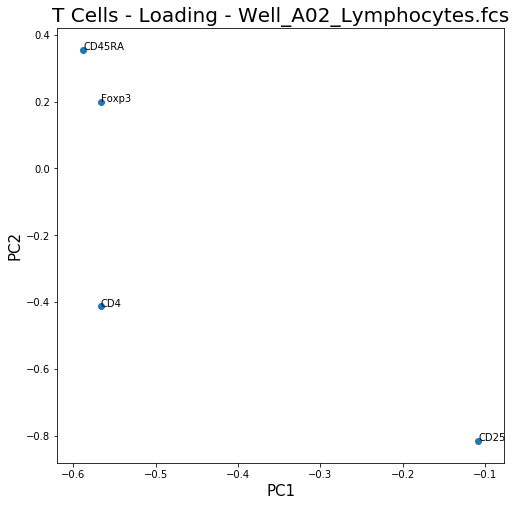

mean pStat activity:  5633.1235
[ 6.6241674   8.196168   -0.07267846 ... -1.1834997   0.5930902
 -1.3611687 ]
[-0.97429574 -1.3900194   1.0868448  ...  0.22033961  1.2133955
  0.09339093]
[3039.5059 1203.093  5533.9526 ... 5284.14   6362.011  5228.115 ]
[[ 6.6241674e+00  8.1961679e+00 -7.2678462e-02 ... -1.1834997e+00
   5.9309018e-01 -1.3611687e+00]
 [-9.7429574e-01 -1.3900194e+00  1.0868448e+00 ...  2.2033961e-01
   1.2133955e+00  9.3390927e-02]
 [ 3.0395059e+03  1.2030930e+03  5.5339526e+03 ...  5.2841401e+03
   6.3620112e+03  5.2281152e+03]]
              x         y       pSTAT5
0      6.624167 -0.974296  3039.505859
1      8.196168 -1.390019  1203.093018
2     -0.072678  1.086845  5533.952637
3      3.310683 -1.264006  6070.749023
4     -1.069627 -1.553247  3357.063232
...         ...       ...          ...
15772  0.469009  1.394255  6438.223145
15773  0.417489  1.014171  6881.919922
15774 -1.183500  0.220340  5284.140137
15775  0.593090  1.213395  6362.011230
15776 -1.361169  0.

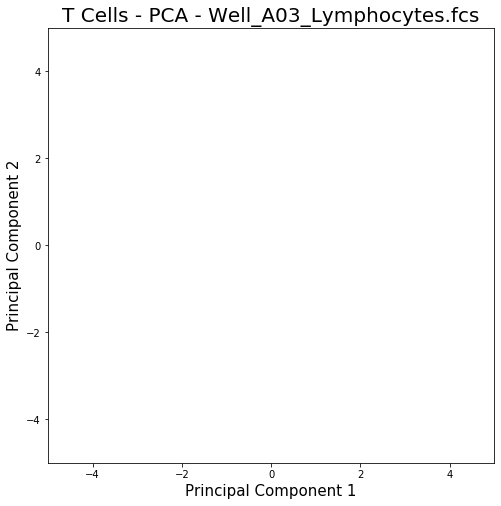

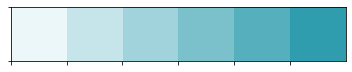

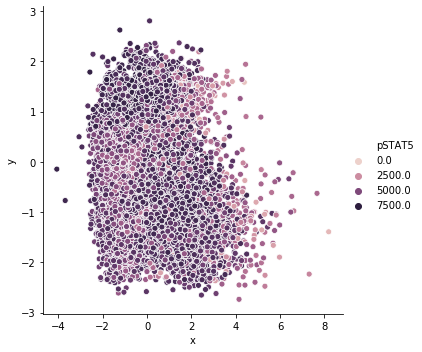

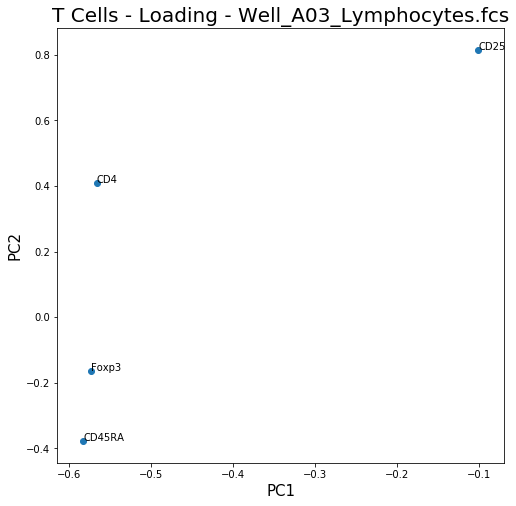

mean pStat activity:  5419.0664
[ 3.2530832   1.5890071  -0.8242476  ...  0.47298747 -1.9754016
  0.51523024]
[ 1.6936351   0.9849029  -0.67061895 ... -1.1385787   0.04235584
 -1.0192311 ]
[4587.918  5873.402  3911.6484 ... 6351.9336 4207.5566 6353.272 ]
[[ 3.2530832e+00  1.5890071e+00 -8.2424760e-01 ...  4.7298747e-01
  -1.9754016e+00  5.1523024e-01]
 [ 1.6936351e+00  9.8490292e-01 -6.7061895e-01 ... -1.1385787e+00
   4.2355839e-02 -1.0192311e+00]
 [ 4.5879180e+03  5.8734019e+03  3.9116484e+03 ...  6.3519336e+03
   4.2075566e+03  6.3532720e+03]]
              x         y       pSTAT5
0      3.253083  1.693635  4587.917969
1      1.589007  0.984903  5873.401855
2     -0.824248 -0.670619  3911.648438
3      0.372482 -0.970691  5389.432617
4      0.203480 -0.952085  6361.557129
...         ...       ...          ...
13852  2.688785  0.832655  5967.479980
13853 -0.300978  0.452669  4154.382812
13854  0.472987 -1.138579  6351.933594
13855 -1.975402  0.042356  4207.556641
13856  0.515230 -1

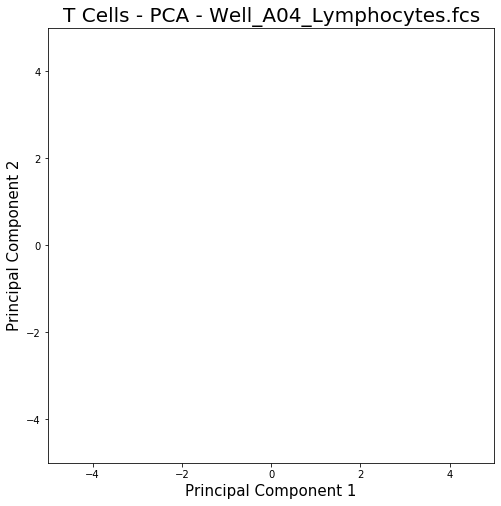

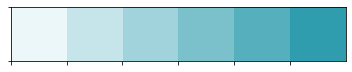

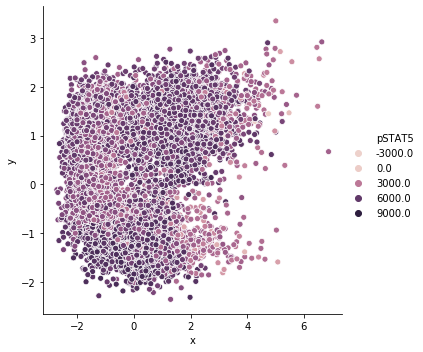

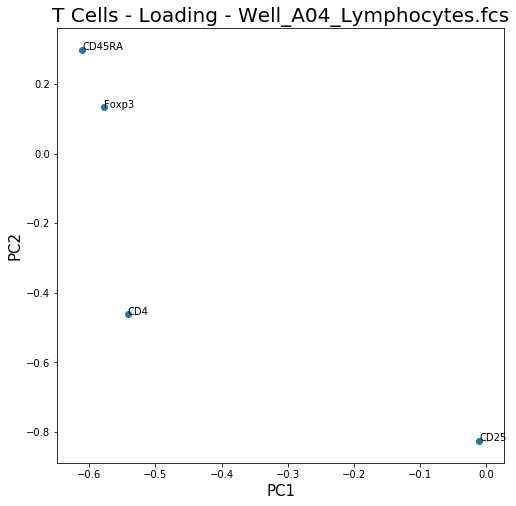

mean pStat activity:  4880.7065
[-0.5737593   0.8166975  -1.1079406  ...  0.30528527  3.608699
  0.05111949]
[-1.092583    1.8027647  -0.3664221  ... -1.2235103   0.58216345
 -1.2314471 ]
[3560.7627 3079.11   5302.463  ... 5796.1104 4289.6313 4645.92  ]
[[-5.7375932e-01  8.1669748e-01 -1.1079406e+00 ...  3.0528527e-01
   3.6086991e+00  5.1119488e-02]
 [-1.0925829e+00  1.8027647e+00 -3.6642209e-01 ... -1.2235103e+00
   5.8216345e-01 -1.2314471e+00]
 [ 3.5607627e+03  3.0791101e+03  5.3024629e+03 ...  5.7961104e+03
   4.2896313e+03  4.6459199e+03]]
              x         y       pSTAT5
0     -0.573759 -1.092583  3560.762695
1      0.816697  1.802765  3079.110107
2     -1.107941 -0.366422  5302.462891
3      1.405479  1.612618  4628.056152
4     -0.036554  1.144966  2456.698730
...         ...       ...          ...
16426 -1.287775  0.472398  4245.881348
16427  1.106284 -1.311479  6109.653320
16428  0.305285 -1.223510  5796.110352
16429  3.608699  0.582163  4289.631348
16430  0.051119 -1.

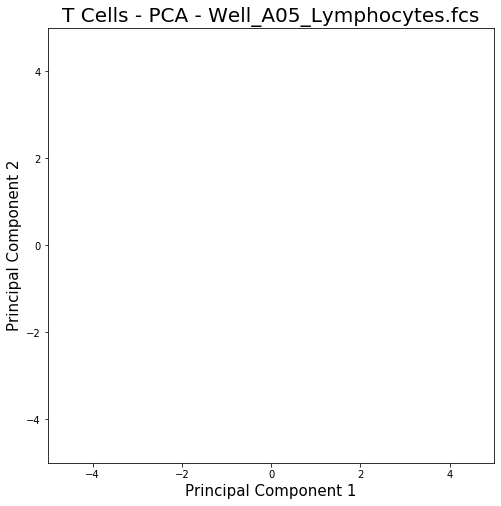

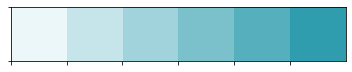

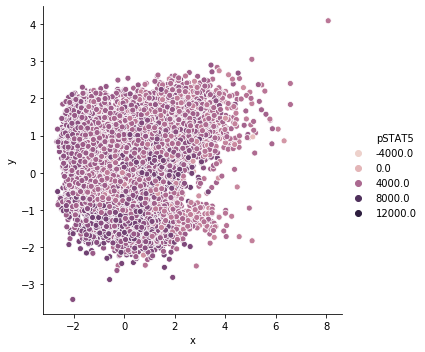

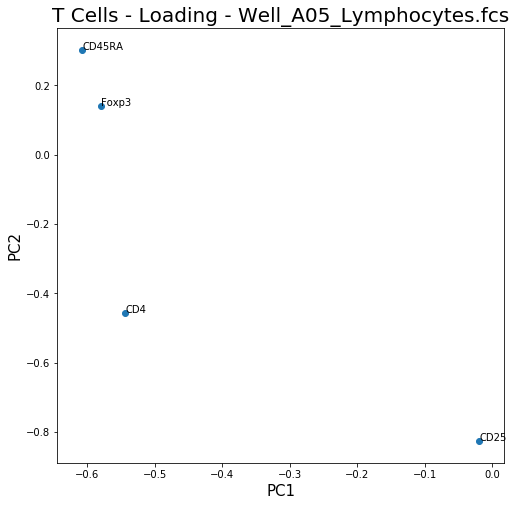

mean pStat activity:  4628.959
[ 4.8802037  -0.99142927 -1.585003   ... -1.438546   -1.0829155
  2.0100603 ]
[ 1.2765466  -0.8806078   0.5846034  ...  0.11952933  0.6163864
  1.2142495 ]
[4100.226  3910.2922 4653.3623 ... 4869.3765 4661.193  4578.629 ]
[[ 4.8802037e+00 -9.9142927e-01 -1.5850030e+00 ... -1.4385459e+00
  -1.0829155e+00  2.0100603e+00]
 [ 1.2765466e+00 -8.8060778e-01  5.8460343e-01 ...  1.1952933e-01
   6.1638641e-01  1.2142495e+00]
 [ 4.1002261e+03  3.9102922e+03  4.6533623e+03 ...  4.8693765e+03
   4.6611929e+03  4.5786289e+03]]
             x         y       pSTAT5
0     4.880204  1.276547  4100.226074
1    -0.991429 -0.880608  3910.292236
2    -1.585003  0.584603  4653.362305
3    -1.345286 -1.041032  4536.430176
4     1.641511  0.583793  5576.132812
...        ...       ...          ...
6691  0.479400 -0.538938  3502.034424
6692 -1.514680 -0.365150  4331.594238
6693 -1.438546  0.119529  4869.376465
6694 -1.082916  0.616386  4661.192871
6695  2.010060  1.214249  4578.

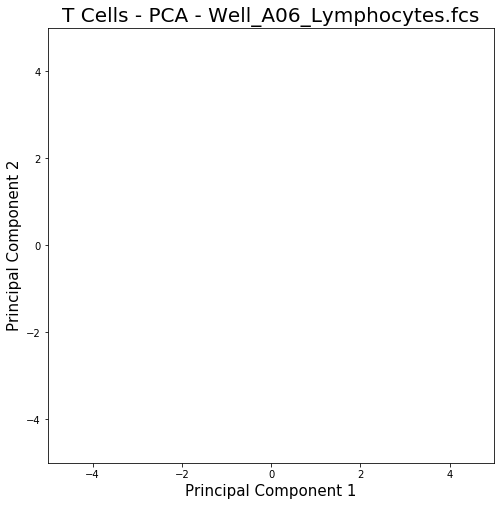

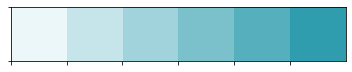

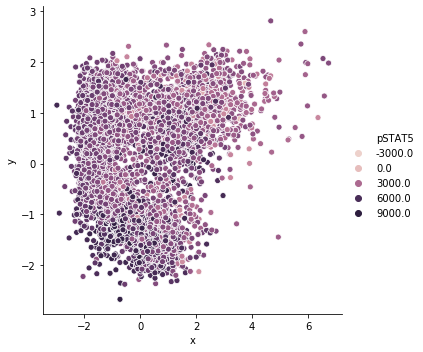

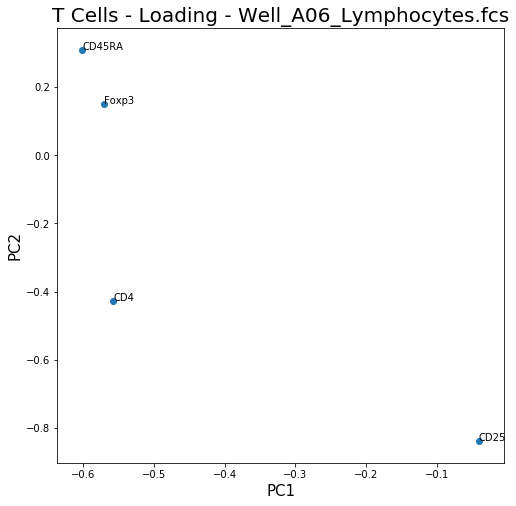

mean pStat activity:  4405.4956
[ 1.96375   -0.8444877  0.5030026 ...  2.8110223  2.199884   2.6025896]
[ 0.7267946   1.7830864  -1.1388943  ... -0.59976244 -0.8965934
 -1.1037045 ]
[3643.468  4330.055  3743.6824 ... 3993.9292 3549.5056 3560.7627]
[[ 1.9637500e+00 -8.4448773e-01  5.0300258e-01 ...  2.8110223e+00
   2.1998839e+00  2.6025896e+00]
 [ 7.2679460e-01  1.7830864e+00 -1.1388943e+00 ... -5.9976244e-01
  -8.9659339e-01 -1.1037045e+00]
 [ 3.6434680e+03  4.3300552e+03  3.7436824e+03 ...  3.9939292e+03
   3.5495056e+03  3.5607627e+03]]
              x         y       pSTAT5
0      1.963750  0.726795  3643.468018
1     -0.844488  1.783086  4330.055176
2      0.503003 -1.138894  3743.682373
3     -1.338817  1.049701  4479.727051
4      0.885977 -1.099740  3500.952881
...         ...       ...          ...
16303 -1.235558 -0.398331  4740.830078
16304  3.243859 -0.875998  3060.239258
16305  2.811022 -0.599762  3993.929199
16306  2.199884 -0.896593  3549.505615
16307  2.602590 -1.103704

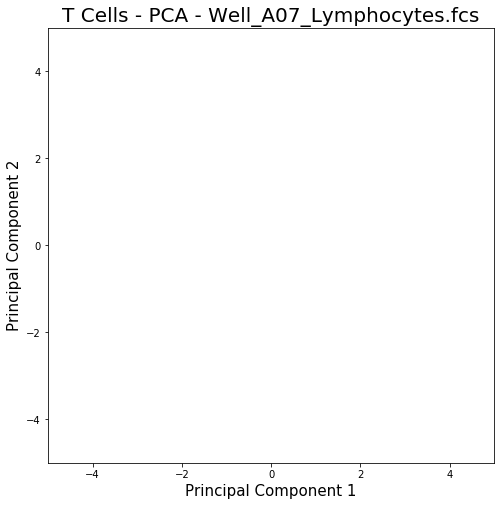

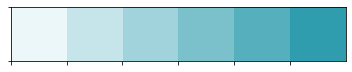

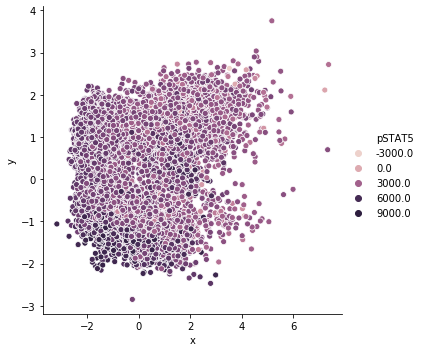

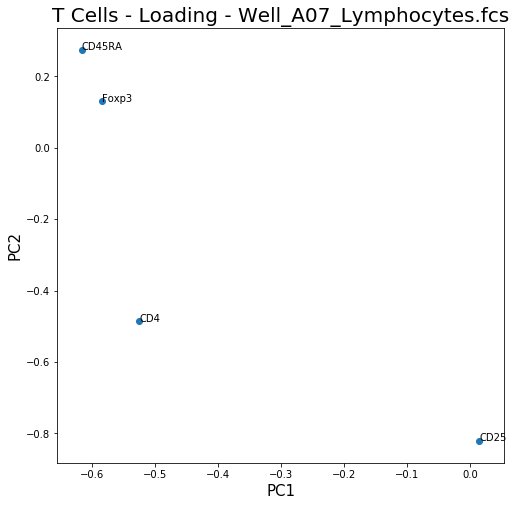

mean pStat activity:  4203.208
[-1.548565   -0.7907391  -1.296903   ... -1.5318542   3.0090613
  0.07544366]
[-0.5672945 -0.1069631 -0.6115455 ...  1.6701139  1.7513357 -1.4213469]
[5761.3022 4482.817  4390.5044 ... 4690.7124 2681.079  4085.234 ]
[[-1.5485650e+00 -7.9073912e-01 -1.2969030e+00 ... -1.5318542e+00
   3.0090613e+00  7.5443655e-02]
 [-5.6729448e-01 -1.0696310e-01 -6.1154550e-01 ...  1.6701139e+00
   1.7513357e+00 -1.4213469e+00]
 [ 5.7613022e+03  4.4828169e+03  4.3905044e+03 ...  4.6907124e+03
   2.6810791e+03  4.0852339e+03]]
              x         y       pSTAT5
0     -1.548565 -0.567294  5761.302246
1     -0.790739 -0.106963  4482.816895
2     -1.296903 -0.611546  4390.504395
3     -0.267181  0.201464  4772.616211
4     -1.777614  0.571686  4583.156738
...         ...       ...          ...
18102 -1.774936  0.862793  4940.702637
18103  0.691818  0.178340  3285.156006
18104 -1.531854  1.670114  4690.712402
18105  3.009061  1.751336  2681.079102
18106  0.075444 -1.421347 

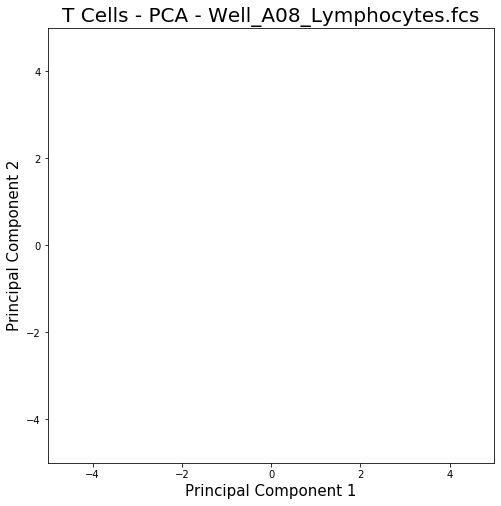

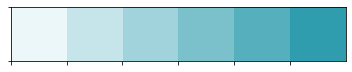

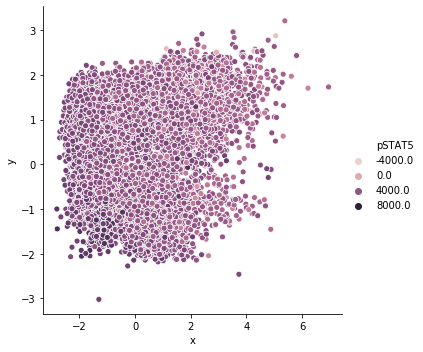

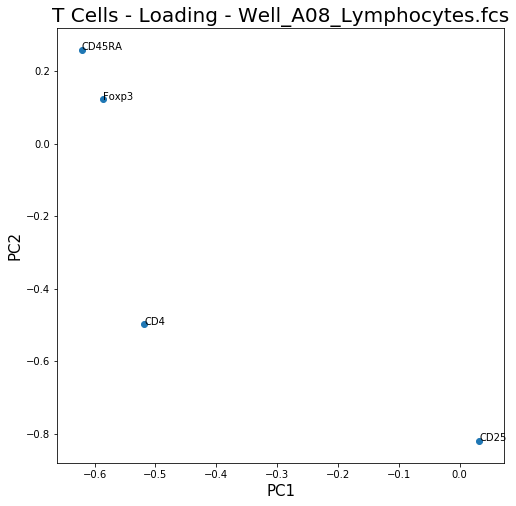

mean pStat activity:  4092.3857
[ 0.7664306  -1.1173505   0.22156036 ... -0.9470238  -1.4522145
  2.2942085 ]
[-1.3993365   1.2857362   1.4301296  ... -0.28864256  1.8748544
  1.3160753 ]
[4277.286  4571.6436 3859.1453 ... 4606.371  4103.4    3105.4084]
[[ 7.6643062e-01 -1.1173505e+00  2.2156036e-01 ... -9.4702381e-01
  -1.4522145e+00  2.2942085e+00]
 [-1.3993365e+00  1.2857362e+00  1.4301296e+00 ... -2.8864256e-01
   1.8748544e+00  1.3160753e+00]
 [ 4.2772861e+03  4.5716436e+03  3.8591453e+03 ...  4.6063711e+03
   4.1033999e+03  3.1054084e+03]]
              x         y       pSTAT5
0      0.766431 -1.399336  4277.286133
1     -1.117350  1.285736  4571.643555
2      0.221560  1.430130  3859.145264
3     -1.749506  1.060170  5064.572754
4      0.344345 -1.182832  4482.200195
...         ...       ...          ...
16255  0.473185  1.150844  4441.504883
16256 -1.460113  0.030505  5153.145996
16257 -0.947024 -0.288643  4606.371094
16258 -1.452214  1.874854  4103.399902
16259  2.294209  1.

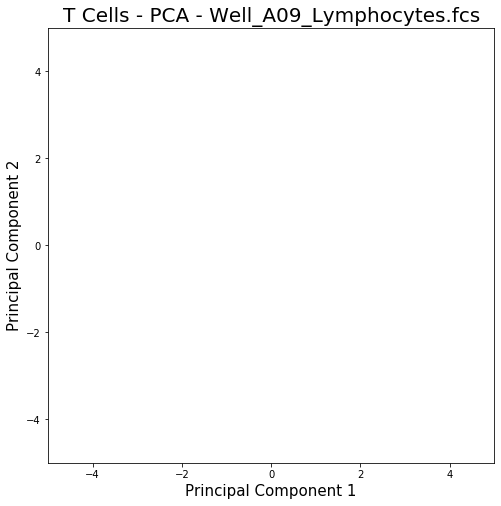

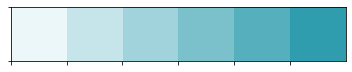

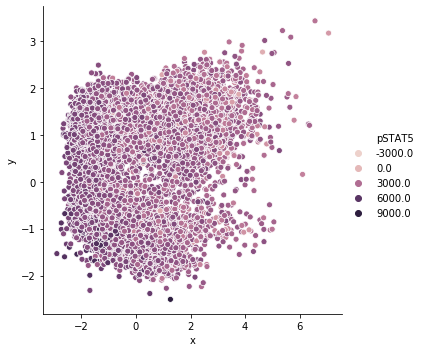

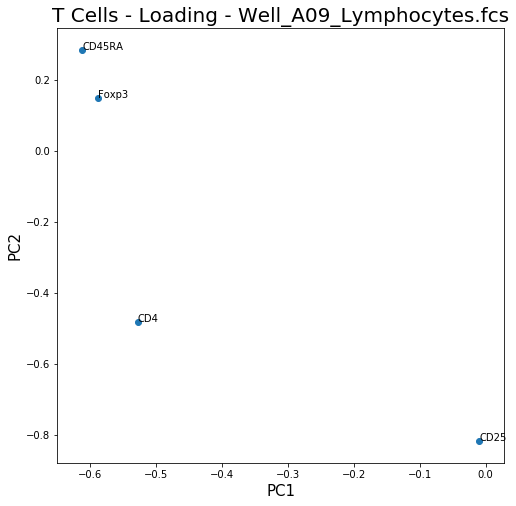

mean pStat activity:  4067.7947
[-1.6038215  -1.5278946  -0.13161631 ... -1.8085864   1.9570472
 -0.5583421 ]
[ 0.38600743  1.3545941   1.30168    ...  0.28730628  1.1865896
 -1.0255272 ]
[4140.962  3266.4458 4217.557  ... 4457.0527 1910.1377 4012.0159]
[[-1.6038215e+00 -1.5278946e+00 -1.3161631e-01 ... -1.8085864e+00
   1.9570472e+00 -5.5834210e-01]
 [ 3.8600743e-01  1.3545941e+00  1.3016800e+00 ...  2.8730628e-01
   1.1865896e+00 -1.0255272e+00]
 [ 4.1409619e+03  3.2664458e+03  4.2175571e+03 ...  4.4570527e+03
   1.9101377e+03  4.0120159e+03]]
              x         y       pSTAT5
0     -1.603822  0.386007  4140.961914
1     -1.527895  1.354594  3266.445801
2     -0.131616  1.301680  4217.557129
3     -1.549064 -0.951692  4259.206543
4      0.048770 -1.312341  3849.687744
...         ...       ...          ...
16878 -0.132943 -0.510432  3545.379150
16879  1.502299  1.437960  3008.654785
16880 -1.808586  0.287306  4457.052734
16881  1.957047  1.186590  1910.137695
16882 -0.558342 -1.

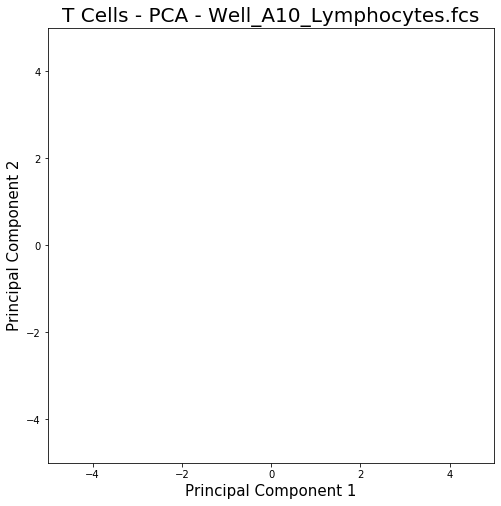

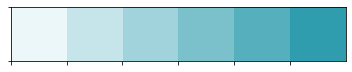

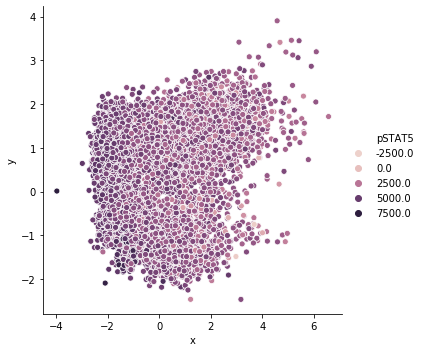

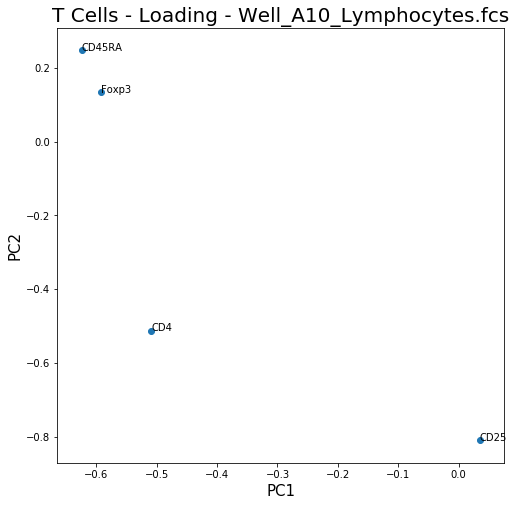

mean pStat activity:  4095.0857
[ 0.8927011  -1.7388206  -0.23250447 ... -1.5845195   8.23837
  3.0679345 ]
[ 0.60540926  0.9501024  -0.76976687 ...  1.1106791   3.7860167
 -0.59109205]
[4004.2307 4724.3345 3976.6567 ... 4190.418  4360.57   2824.2866]
[[ 8.9270109e-01 -1.7388206e+00 -2.3250447e-01 ... -1.5845195e+00
   8.2383699e+00  3.0679345e+00]
 [ 6.0540926e-01  9.5010239e-01 -7.6976687e-01 ...  1.1106791e+00
   3.7860167e+00 -5.9109205e-01]
 [ 4.0042307e+03  4.7243345e+03  3.9766567e+03 ...  4.1904180e+03
   4.3605698e+03  2.8242866e+03]]
              x         y       pSTAT5
0      0.892701  0.605409  4004.230713
1     -1.738821  0.950102  4724.334473
2     -0.232504 -0.769767  3976.656738
3     -2.311900  1.422482  5030.315918
4      1.384591  1.039446  3655.484863
...         ...       ...          ...
18442 -1.825238  1.489039  4551.908203
18443 -0.269709 -0.773958  4182.405273
18444 -1.584520  1.110679  4190.417969
18445  8.238370  3.786017  4360.569824
18446  3.067935 -0.59

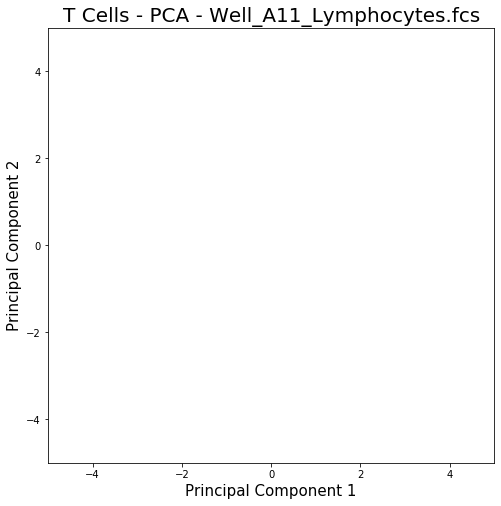

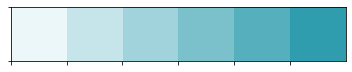

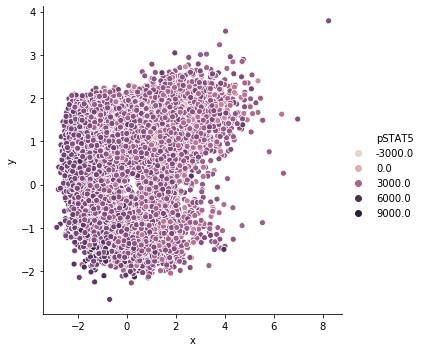

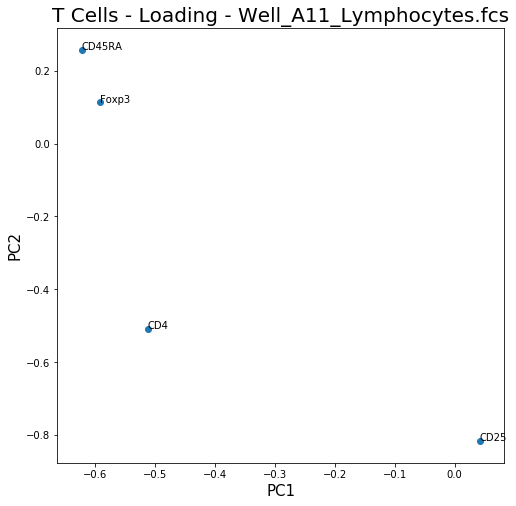

mean pStat activity:  4089.784
[-1.9110211   0.11241869  0.40025812 ...  0.14834037  0.39467925
 -0.37664983]
[ 0.8687149  -1.5029197  -0.77102584 ... -0.42680678 -1.4818641
 -0.9221284 ]
[3803.7952 4641.56   4335.808  ... 4183.3525 4009.031  4321.1416]
[[-1.9110211e+00  1.1241869e-01  4.0025812e-01 ...  1.4834037e-01
   3.9467925e-01 -3.7664983e-01]
 [ 8.6871493e-01 -1.5029197e+00 -7.7102584e-01 ... -4.2680678e-01
  -1.4818641e+00 -9.2212838e-01]
 [ 3.8037952e+03  4.6415601e+03  4.3358081e+03 ...  4.1833525e+03
   4.0090310e+03  4.3211416e+03]]
              x         y       pSTAT5
0     -1.911021  0.868715  3803.795166
1      0.112419 -1.502920  4641.560059
2      0.400258 -0.771026  4335.808105
3      0.442258 -1.520929  4578.628906
4      0.287962 -1.273599  4439.207520
...         ...       ...          ...
15191  0.067234  1.344369  3278.508301
15192  0.644636 -1.304584  4413.413086
15193  0.148340 -0.426807  4183.352539
15194  0.394679 -1.481864  4009.031006
15195 -0.376650 -0.

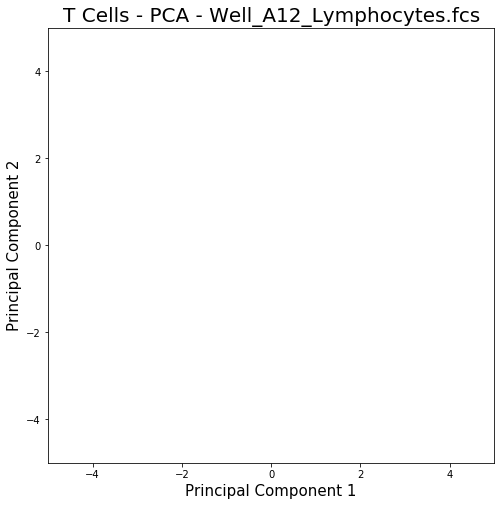

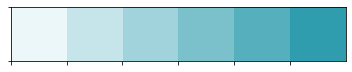

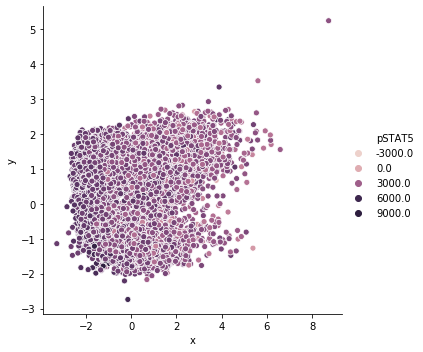

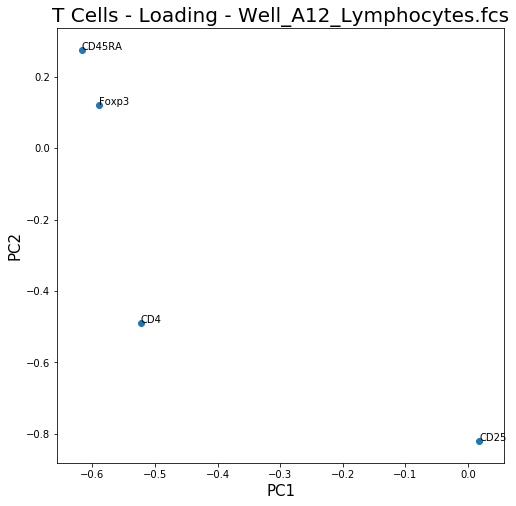

mean pStat activity:  5467.946
[-1.2763906  -0.7797909   0.3247537  ... -0.77298963  0.42633379
  1.6153268 ]
[ 1.1611991  1.0606697 -1.2406952 ...  0.7240744 -1.2942162  2.4062352]
[4344.5376 3931.721  6583.0757 ... 5199.0566 6394.942  5772.167 ]
[[-1.2763906e+00 -7.7979088e-01  3.2475370e-01 ... -7.7298963e-01
   4.2633379e-01  1.6153268e+00]
 [ 1.1611991e+00  1.0606697e+00 -1.2406952e+00 ...  7.2407442e-01
  -1.2942162e+00  2.4062352e+00]
 [ 4.3445376e+03  3.9317209e+03  6.5830757e+03 ...  5.1990566e+03
   6.3949419e+03  5.7721670e+03]]
              x         y       pSTAT5
0     -1.276391  1.161199  4344.537598
1     -0.779791  1.060670  3931.720947
2      0.324754 -1.240695  6583.075684
3     -0.263565  1.095946  6113.250000
4     -0.280581  1.267334  6161.081543
...         ...       ...          ...
13029  0.614691  0.228441  6374.644043
13030  0.900049 -0.354601  4088.471924
13031 -0.772990  0.724074  5199.056641
13032  0.426334 -1.294216  6394.941895
13033  1.615327  2.406235

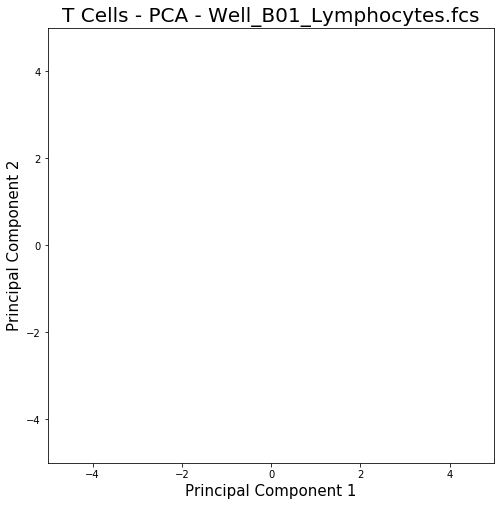

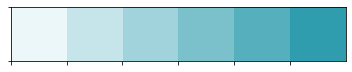

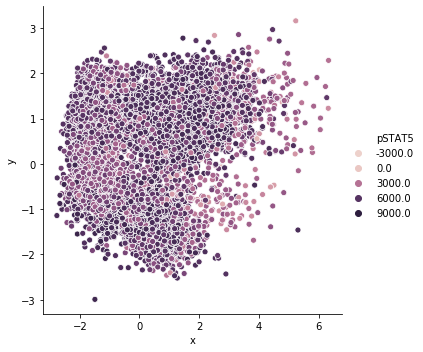

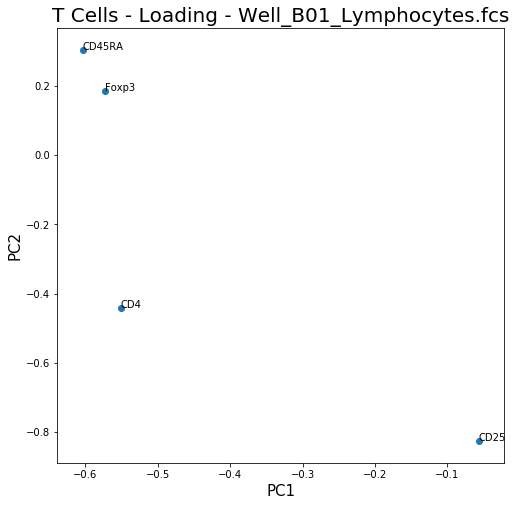

mean pStat activity:  5367.9775
[ 7.6846027  -1.3637182   0.6249546  ...  1.5942516   1.6499251
  0.21477193]
[ 1.0267352   0.93198043 -1.466689   ... -1.7324015  -1.8114647
 -1.1221459 ]
[3966.611  5279.9644 6125.124  ... 3085.3438 4459.9287 4513.8477]
[[ 7.6846027e+00 -1.3637182e+00  6.2495458e-01 ...  1.5942516e+00
   1.6499251e+00  2.1477193e-01]
 [ 1.0267352e+00  9.3198043e-01 -1.4666890e+00 ... -1.7324015e+00
  -1.8114647e+00 -1.1221459e+00]
 [ 3.9666111e+03  5.2799644e+03  6.1251240e+03 ...  3.0853438e+03
   4.4599287e+03  4.5138477e+03]]
              x         y       pSTAT5
0      7.684603  1.026735  3966.611084
1     -1.363718  0.931980  5279.964355
2      0.624955 -1.466689  6125.124023
3     -0.331265  1.036741  5888.172852
4     -0.330184 -0.721302  6089.919922
...         ...       ...          ...
15148  1.075331  1.681039  5906.939941
15149  2.959982 -1.113082    13.777188
15150  1.594252 -1.732401  3085.343750
15151  1.649925 -1.811465  4459.928711
15152  0.214772 -1.

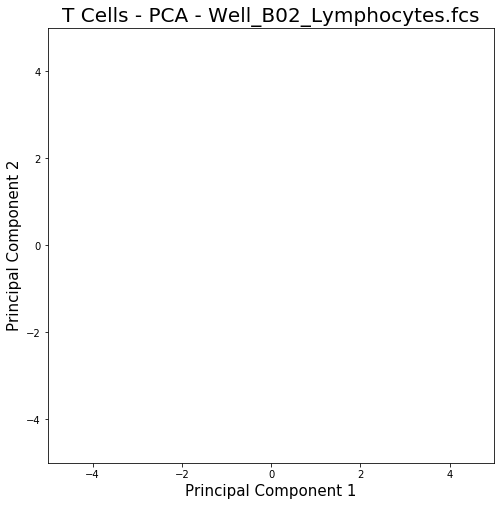

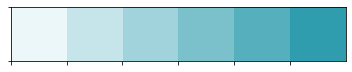

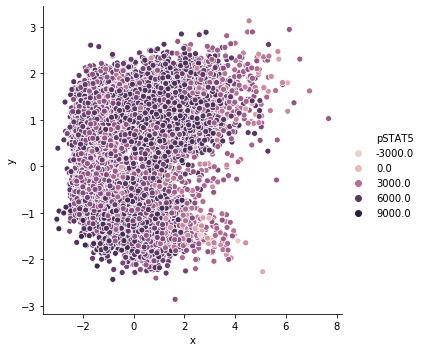

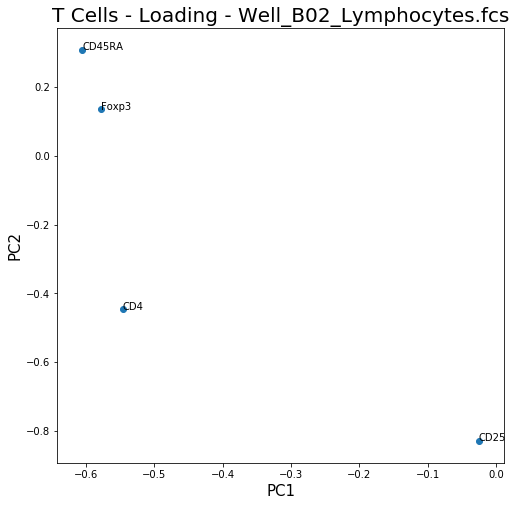

mean pStat activity:  5495.8945
[-0.648571    1.4884889  -1.4131505  ... -0.44826072 -1.7912438
 -1.4593105 ]
[-1.2726737   0.6255233  -1.0563618  ...  1.7186453   0.79546964
  0.98798746]
[7048.467  6531.2773 5008.145  ... 4408.617  4779.735  6054.536 ]
[[-6.4857101e-01  1.4884889e+00 -1.4131505e+00 ... -4.4826072e-01
  -1.7912438e+00 -1.4593105e+00]
 [-1.2726737e+00  6.2552333e-01 -1.0563618e+00 ...  1.7186453e+00
   7.9546964e-01  9.8798746e-01]
 [ 7.0484668e+03  6.5312773e+03  5.0081450e+03 ...  4.4086172e+03
   4.7797349e+03  6.0545361e+03]]
              x         y       pSTAT5
0     -0.648571 -1.272674  7048.466797
1      1.488489  0.625523  6531.277344
2     -1.413151 -1.056362  5008.145020
3      2.312847  1.075377  2030.994507
4     -1.064265  0.888683  4437.231934
...         ...       ...          ...
12759  0.368834 -1.299096  3996.365479
12760 -0.146535 -1.149768  6091.745117
12761 -0.448261  1.718645  4408.617188
12762 -1.791244  0.795470  4779.734863
12763 -1.459311  0

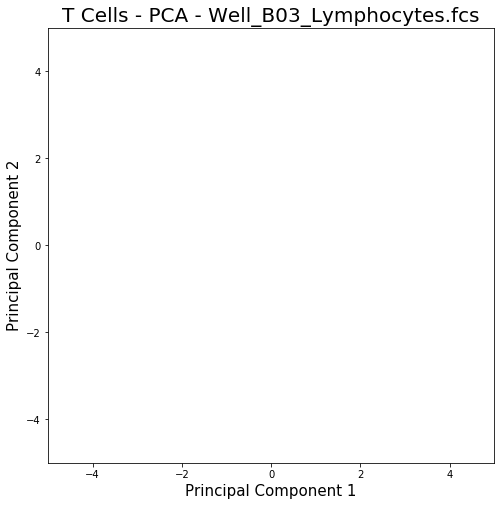

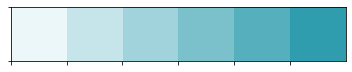

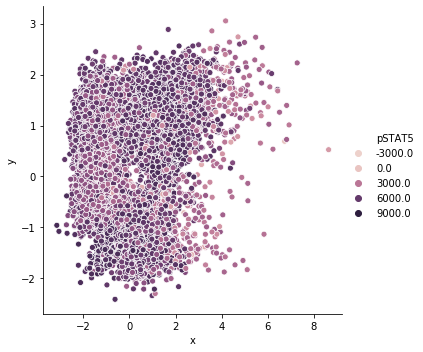

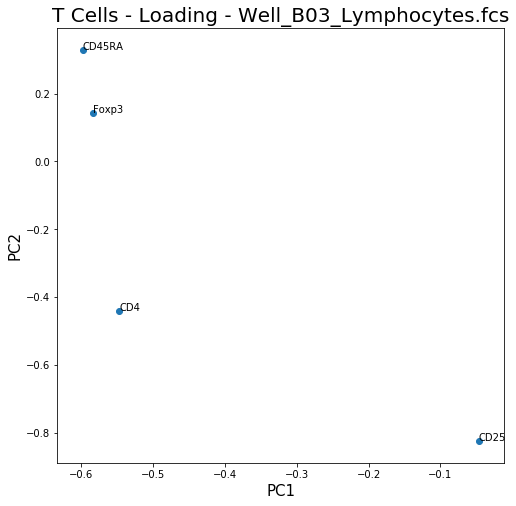

mean pStat activity:  5186.5786
[-1.8684162  -0.11138359  2.9662263  ...  1.7216519  -1.8349235
  0.7750857 ]
[ 1.0782077  -0.94235307 -1.2653295  ...  1.897814   -0.9010202
  1.5269878 ]
[6228.374  5755.817  5270.351  ... 6335.5464 5670.7563 6336.8735]
[[-1.86841619e+00 -1.11383595e-01  2.96622634e+00 ...  1.72165191e+00
  -1.83492351e+00  7.75085688e-01]
 [ 1.07820773e+00 -9.42353070e-01 -1.26532948e+00 ...  1.89781404e+00
  -9.01020229e-01  1.52698779e+00]
 [ 6.22837402e+03  5.75581689e+03  5.27035107e+03 ...  6.33554639e+03
   5.67075635e+03  6.33687354e+03]]
              x         y       pSTAT5
0     -1.868416  1.078208  6228.374023
1     -0.111384 -0.942353  5755.816895
2      2.966226 -1.265329  5270.351074
3     -2.081645  0.116661  3973.531494
4      0.307600  1.229085  6110.066406
...         ...       ...          ...
14914  0.514362  1.195419  4129.841797
14915  3.404932 -2.358633  1347.037720
14916  1.721652  1.897814  6335.546387
14917 -1.834924 -0.901020  5670.756348
1

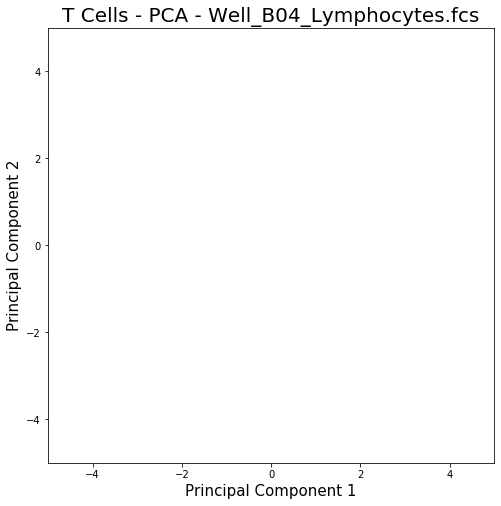

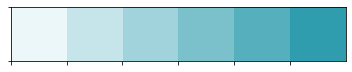

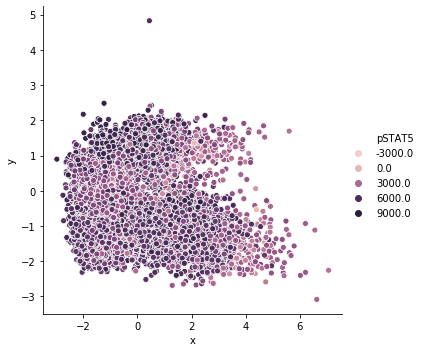

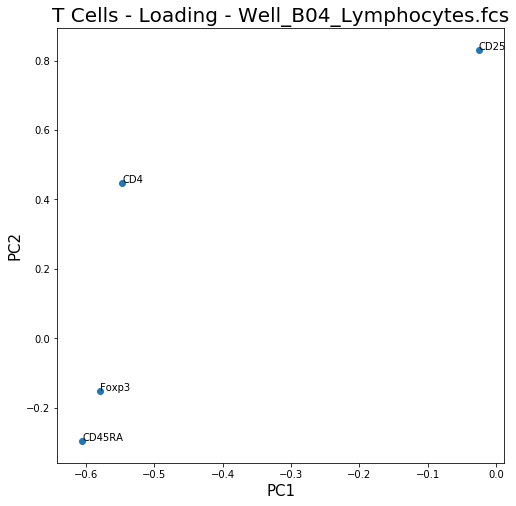

mean pStat activity:  4539.8184
[ 9.093414    0.09817532  0.6571106  ... -1.7865431   0.03592543
  2.215153  ]
[ 3.1962686 -1.5477501 -1.543573  ... -1.5275829  1.456778   2.1199393]
[3109.9968 4396.1284 5164.193  ... 6209.946  3169.6958 2074.7   ]
[[ 9.0934143e+00  9.8175324e-02  6.5711057e-01 ... -1.7865431e+00
   3.5925433e-02  2.2151530e+00]
 [ 3.1962686e+00 -1.5477501e+00 -1.5435730e+00 ... -1.5275829e+00
   1.4567780e+00  2.1199393e+00]
 [ 3.1099968e+03  4.3961284e+03  5.1641929e+03 ...  6.2099458e+03
   3.1696958e+03  2.0747000e+03]]
              x         y       pSTAT5
0      9.093414  3.196269  3109.996826
1      0.098175 -1.547750  4396.128418
2      0.657111 -1.543573  5164.192871
3      0.527461 -1.223569  6128.251953
4      0.441838 -1.102901  5450.079590
...         ...       ...          ...
16115 -0.244224  0.410647  4520.877441
16116  3.391007 -1.578908  3329.362305
16117 -1.786543 -1.527583  6209.945801
16118  0.035925  1.456778  3169.695801
16119  2.215153  2.11993

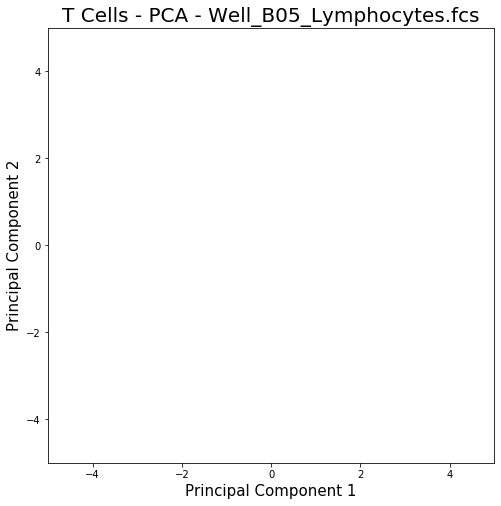

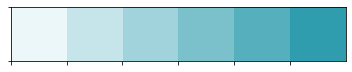

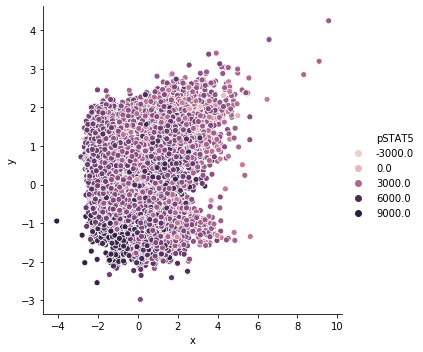

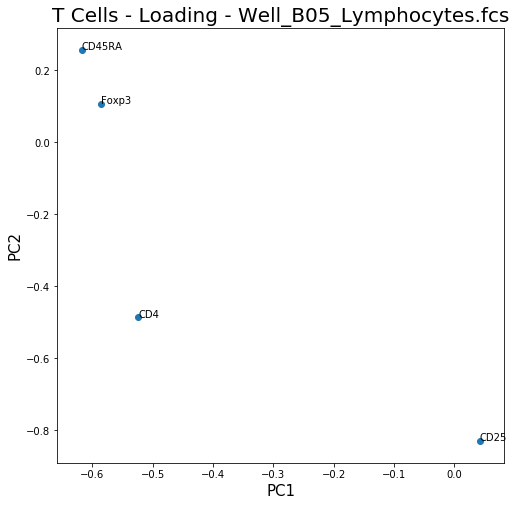

mean pStat activity:  4185.207
[-0.8470598   0.5444311  -0.51617223 ...  1.391651    0.4282315
 -1.1213557 ]
[-1.2720063   0.11554964  0.12065277 ... -0.36383557  1.8515577
 -0.8275924 ]
[4347.173  4369.7236 5222.274  ... 2745.393  4482.5083 4778.751 ]
[[-8.4705979e-01  5.4443109e-01 -5.1617223e-01 ...  1.3916510e+00
   4.2823151e-01 -1.1213557e+00]
 [-1.2720063e+00  1.1554964e-01  1.2065277e-01 ... -3.6383557e-01
   1.8515577e+00 -8.2759237e-01]
 [ 4.3471729e+03  4.3697236e+03  5.2222739e+03 ...  2.7453931e+03
   4.4825083e+03  4.7787510e+03]]
             x         y       pSTAT5
0    -0.847060 -1.272006  4347.172852
1     0.544431  0.115550  4369.723633
2    -0.516172  0.120653  5222.273926
3    -1.642576  0.277300  4314.479492
4    -1.315289 -1.058146  4336.953125
...        ...       ...          ...
2672 -1.688776 -0.720227  4383.052246
2673 -1.666877  0.429736  4426.599609
2674  1.391651 -0.363836  2745.393066
2675  0.428232  1.851558  4482.508301
2676 -1.121356 -0.827592  4778.

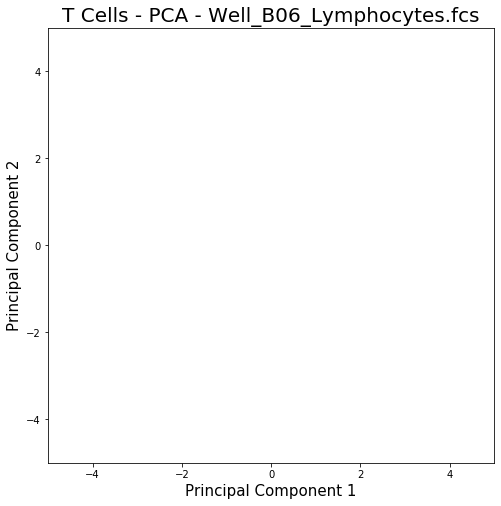

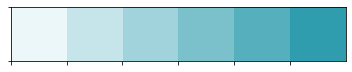

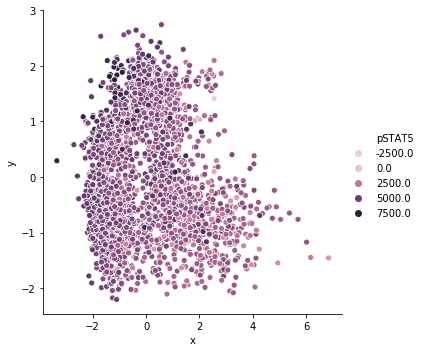

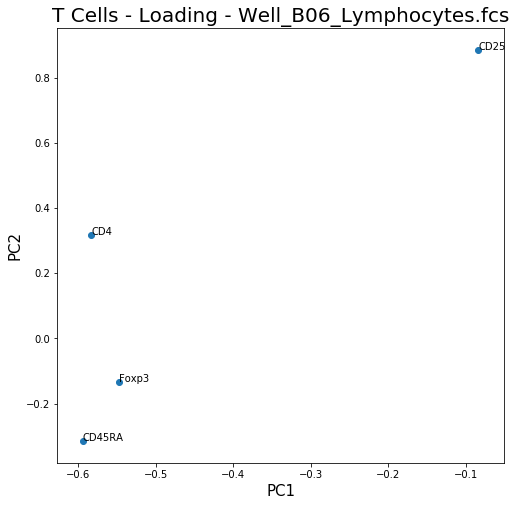

mean pStat activity:  4056.6846
[8.239055  0.9766301 1.3791529 ... 2.8125608 2.349471  3.083009 ]
[ 2.951597  -0.0958489  0.8103436 ... -0.6198521 -1.1428199 -0.9208355]
[4273.54   2172.7317 3917.7239 ... 3055.4817 2412.9143 3011.933 ]
[[ 8.2390547e+00  9.7663009e-01  1.3791529e+00 ...  2.8125608e+00
   2.3494711e+00  3.0830090e+00]
 [ 2.9515970e+00 -9.5848896e-02  8.1034362e-01 ... -6.1985213e-01
  -1.1428199e+00 -9.2083549e-01]
 [ 4.2735400e+03  2.1727317e+03  3.9177239e+03 ...  3.0554817e+03
   2.4129143e+03  3.0119331e+03]]
              x         y       pSTAT5
0      8.239055  2.951597  4273.540039
1      0.976630 -0.095849  2172.731689
2      1.379153  0.810344  3917.723877
3      1.761754  1.129799  4087.933105
4      0.616923 -1.550226  2756.867188
...         ...       ...          ...
14069 -1.387173  1.759872  4744.993164
14070  3.430992 -1.243082  3544.344727
14071  2.812561 -0.619852  3055.481689
14072  2.349471 -1.142820  2412.914307
14073  3.083009 -0.920835  3011.93310

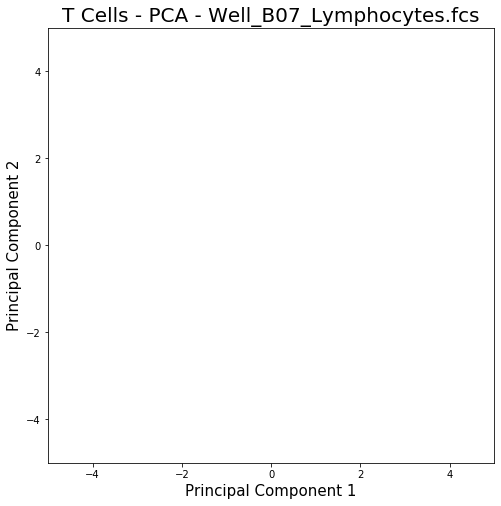

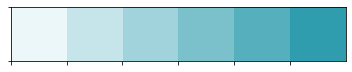

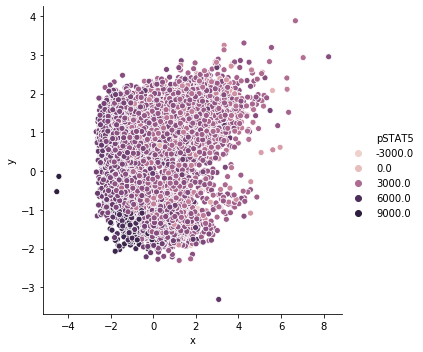

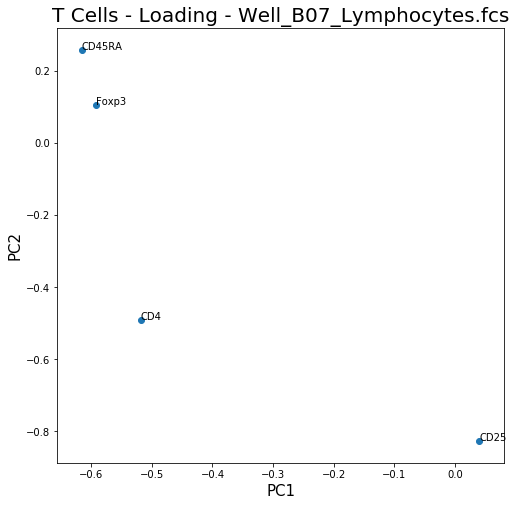

mean pStat activity:  4008.374
[-1.3973916   0.78932476 -1.9217672  ...  2.730179    2.2973433
  1.61535   ]
[-0.5823488   0.91522044  1.0831195  ... -0.5493086  -0.4261493
 -1.1716145 ]
[1426.4121 3833.4292 4533.291  ... 3452.163  2675.1318 3671.8623]
[[-1.3973916e+00  7.8932476e-01 -1.9217672e+00 ...  2.7301791e+00
   2.2973433e+00  1.6153500e+00]
 [-5.8234882e-01  9.1522044e-01  1.0831195e+00 ... -5.4930860e-01
  -4.2614931e-01 -1.1716145e+00]
 [ 1.4264121e+03  3.8334292e+03  4.5332910e+03 ...  3.4521631e+03
   2.6751318e+03  3.6718623e+03]]
              x         y       pSTAT5
0     -1.397392 -0.582349  1426.412109
1      0.789325  0.915220  3833.429199
2     -1.921767  1.083120  4533.291016
3     -2.076903 -0.428786  4416.479004
4     -0.903181  1.124967  4029.685303
...         ...       ...          ...
18621  2.789953 -1.253450  2350.515137
18622  4.495023 -0.244473  3433.821777
18623  2.730179 -0.549309  3452.163086
18624  2.297343 -0.426149  2675.131836
18625  1.615350 -1.1

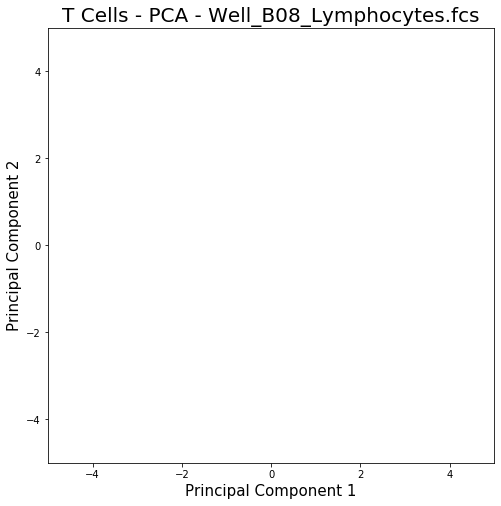

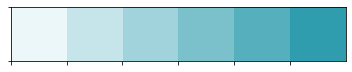

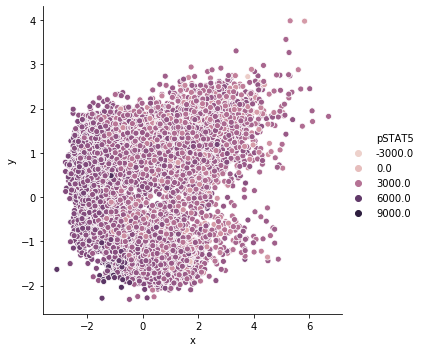

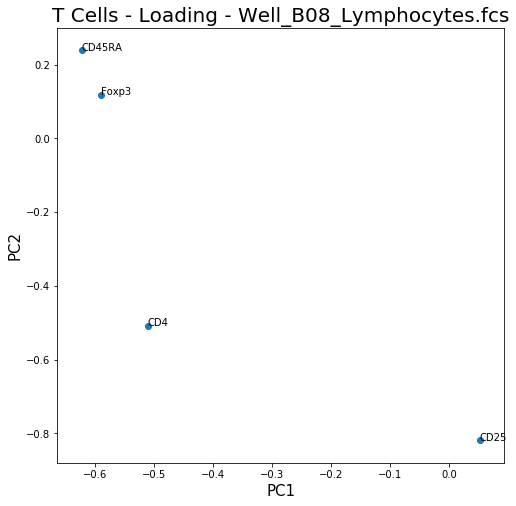

mean pStat activity:  3990.2983
[ 0.5206913 -1.0134428  2.6160495 ...  1.2314761 -1.473433   2.443778 ]
[-1.62329    -0.92718756  1.0653775  ...  1.2301358  -0.72477484
  1.4462007 ]
[4180.982  4295.724  3069.7068 ... 4202.965  4792.7793 4236.7104]
[[ 5.2069128e-01 -1.0134428e+00  2.6160495e+00 ...  1.2314761e+00
  -1.4734330e+00  2.4437780e+00]
 [-1.6232899e+00 -9.2718756e-01  1.0653775e+00 ...  1.2301358e+00
  -7.2477484e-01  1.4462007e+00]
 [ 4.1809819e+03  4.2957241e+03  3.0697068e+03 ...  4.2029648e+03
   4.7927793e+03  4.2367104e+03]]
              x         y       pSTAT5
0      0.520691 -1.623290  4180.981934
1     -1.013443 -0.927188  4295.724121
2      2.616050  1.065377  3069.706787
3      0.573345 -1.243550  2540.119873
4      0.656085 -1.437842  4582.891113
...         ...       ...          ...
17512  1.808213  0.037762  4056.567627
17513  2.844932  1.605193  3857.697510
17514  1.231476  1.230136  4202.964844
17515 -1.473433 -0.724775  4792.779297
17516  2.443778  1.44620

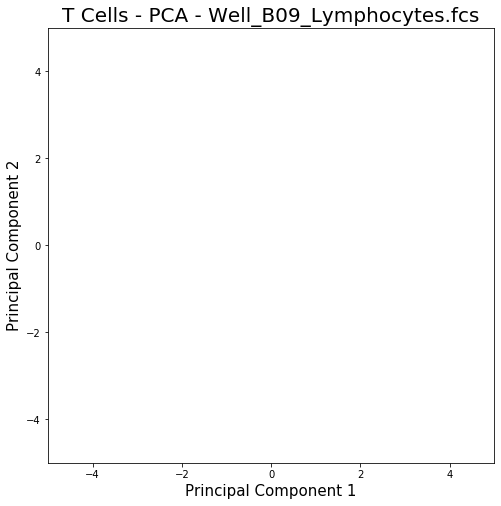

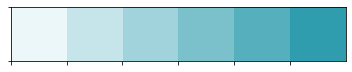

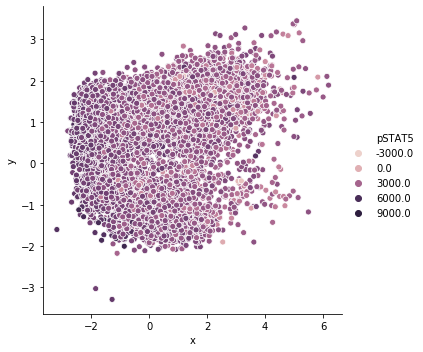

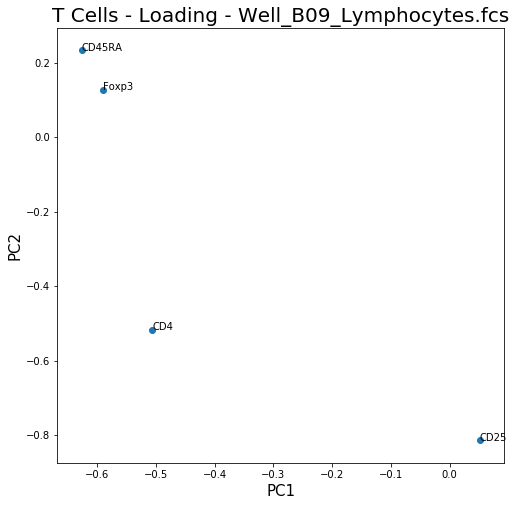

mean pStat activity:  3999.723
[-2.6505158  -0.4353826   0.6440045  ... -0.99297446  1.893205
  3.684351  ]
[-0.9560411  -0.26634935 -1.102966   ...  0.99242455 -1.2295713
 -1.2077273 ]
[4745.8228 2813.22   4002.4226 ... 4345.668  1942.457  2891.03  ]
[[-2.6505158e+00 -4.3538260e-01  6.4400452e-01 ... -9.9297446e-01
   1.8932050e+00  3.6843510e+00]
 [-9.5604110e-01 -2.6634935e-01 -1.1029660e+00 ...  9.9242455e-01
  -1.2295713e+00 -1.2077273e+00]
 [ 4.7458228e+03  2.8132200e+03  4.0024226e+03 ...  4.3456680e+03
   1.9424570e+03  2.8910300e+03]]
              x         y       pSTAT5
0     -2.650516 -0.956041  4745.822754
1     -0.435383 -0.266349  2813.219971
2      0.644005 -1.102966  4002.422607
3     -1.961167 -0.536719  4473.503906
4      0.917063 -1.514276  2653.181885
...         ...       ...          ...
17547 -0.012401 -1.191398  3962.810303
17548 -0.428252 -0.942858  4169.977051
17549 -0.992974  0.992425  4345.667969
17550  1.893205 -1.229571  1942.457031
17551  3.684351 -1.20

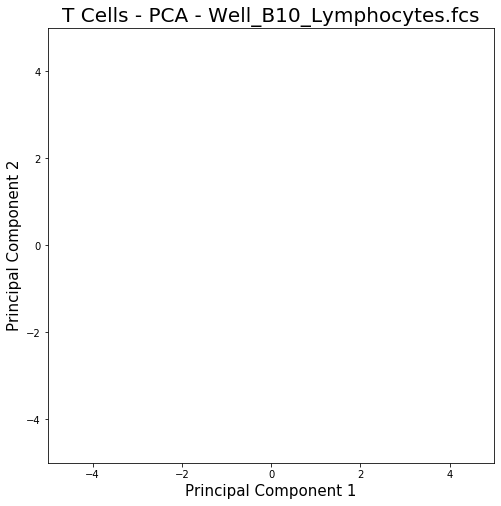

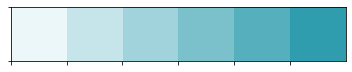

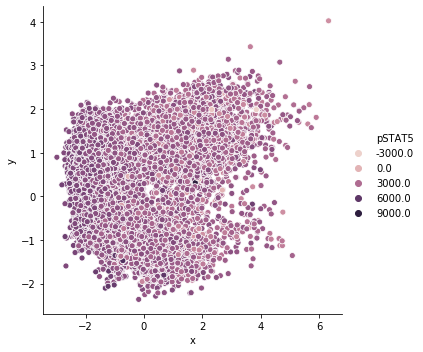

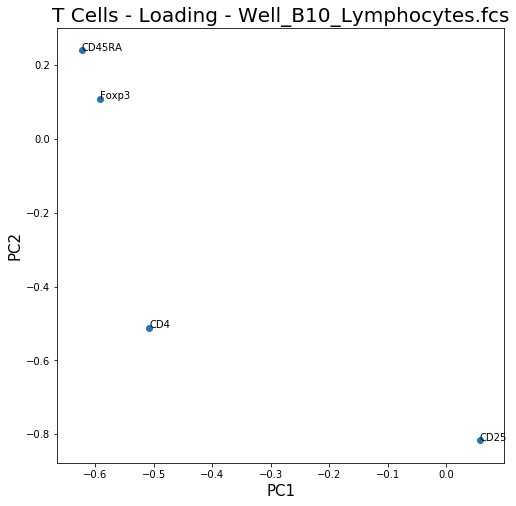

mean pStat activity:  4042.6301
[ 2.02323     0.61187494 -0.07932951 ... -1.1855917  -1.9484245
 -2.1789048 ]
[ 1.3393165  -1.3879583  -1.1334532  ... -0.58301574  0.9763427
  0.55535656]
[2067.4429 3792.1104 3882.6697 ... 4367.5376 4528.987  4628.304 ]
[[ 2.0232301e+00  6.1187494e-01 -7.9329513e-02 ... -1.1855917e+00
  -1.9484245e+00 -2.1789048e+00]
 [ 1.3393165e+00 -1.3879583e+00 -1.1334532e+00 ... -5.8301574e-01
   9.7634268e-01  5.5535656e-01]
 [ 2.0674429e+03  3.7921104e+03  3.8826697e+03 ...  4.3675376e+03
   4.5289868e+03  4.6283042e+03]]
              x         y       pSTAT5
0      2.023230  1.339316  2067.442871
1      0.611875 -1.387958  3792.110352
2     -0.079330 -1.133453  3882.669678
3      1.789149  2.209064  3875.613037
4     -1.806626 -0.482675  4386.965820
...         ...       ...          ...
17844 -1.794924  1.172734  4872.959473
17845 -1.104363 -0.744341  4384.121582
17846 -1.185592 -0.583016  4367.537598
17847 -1.948424  0.976343  4528.986816
17848 -2.178905  0.

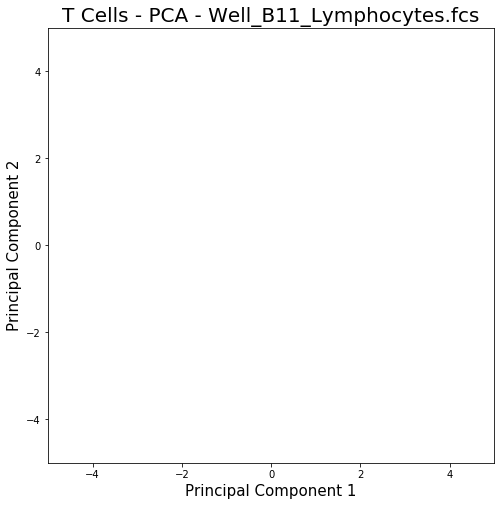

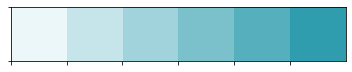

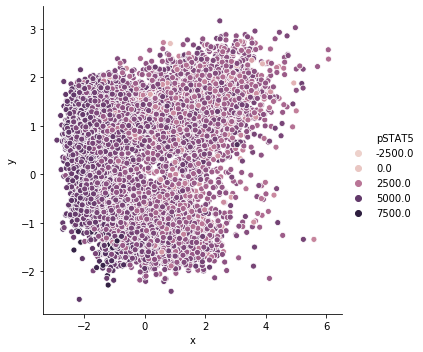

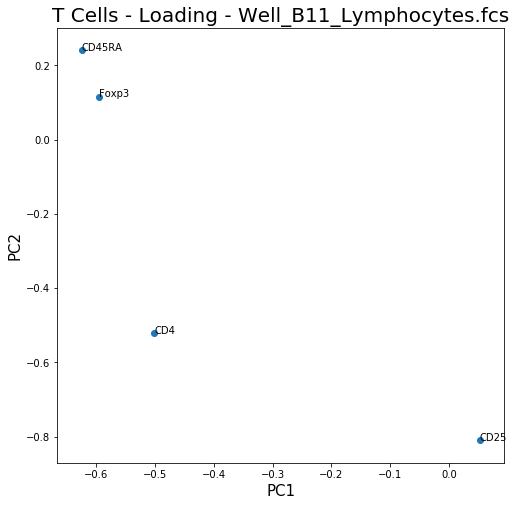

mean pStat activity:  4052.7458
[ 0.6218504   1.5523417  -2.0646636  ...  0.88801736 -0.5675773
 -2.059678  ]
[-1.1506499   1.0077692   0.8266121  ... -1.4303799  -0.68426967
 -0.70236015]
[3938.955  4057.6904 4773.2124 ... 4025.0134 4541.253  4663.077 ]
[[ 6.2185037e-01  1.5523417e+00 -2.0646636e+00 ...  8.8801736e-01
  -5.6757730e-01 -2.0596781e+00]
 [-1.1506499e+00  1.0077692e+00  8.2661211e-01 ... -1.4303799e+00
  -6.8426967e-01 -7.0236015e-01]
 [ 3.9389551e+03  4.0576904e+03  4.7732124e+03 ...  4.0250134e+03
   4.5412529e+03  4.6630771e+03]]
              x         y       pSTAT5
0      0.621850 -1.150650  3938.955078
1      1.552342  1.007769  4057.690430
2     -2.064664  0.826612  4773.212402
3      1.988279  0.724414  2743.474121
4     -0.910111  0.718899  3230.888184
...         ...       ...          ...
15916  1.786529  1.874840  4791.622070
15917  0.945355 -1.348642  3751.947510
15918  0.888017 -1.430380  4025.013428
15919 -0.567577 -0.684270  4541.252930
15920 -2.059678 -0

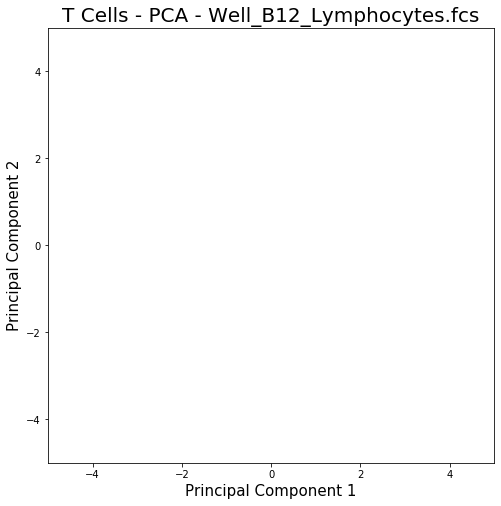

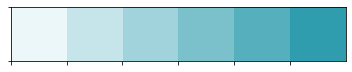

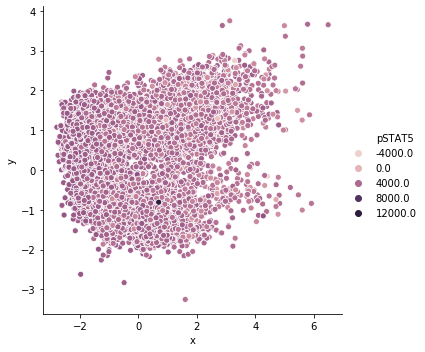

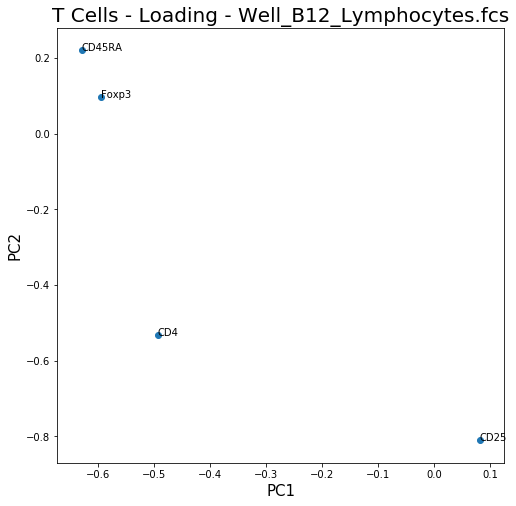

mean pStat activity:  5402.8276
[ 2.770767   -0.0147177   0.22644977 ... -1.4292696  -1.394949
 -2.0152967 ]
[ 0.76402915  0.5824921  -2.0147316  ...  1.3674736  -0.8408497
 -0.43084332]
[6057.8486 6190.155  4066.06   ... 5919.0435 3834.9207 4889.255 ]
[[ 2.7707670e+00 -1.4717702e-02  2.2644977e-01 ... -1.4292696e+00
  -1.3949490e+00 -2.0152967e+00]
 [ 7.6402915e-01  5.8249211e-01 -2.0147316e+00 ...  1.3674736e+00
  -8.4084970e-01 -4.3084332e-01]
 [ 6.0578486e+03  6.1901548e+03  4.0660601e+03 ...  5.9190435e+03
   3.8349207e+03  4.8892549e+03]]
              x         y       pSTAT5
0      2.770767  0.764029  6057.848633
1     -0.014718  0.582492  6190.154785
2      0.226450 -2.014732  4066.060059
3     -1.175077  0.411018  4454.164062
4     -1.127962 -0.202265  5050.191895
...         ...       ...          ...
14736 -1.834750  1.545505  4372.265137
14737  3.431216 -1.321203  3408.059570
14738 -1.429270  1.367474  5919.043457
14739 -1.394949 -0.840850  3834.920654
14740 -2.015297 -0.4

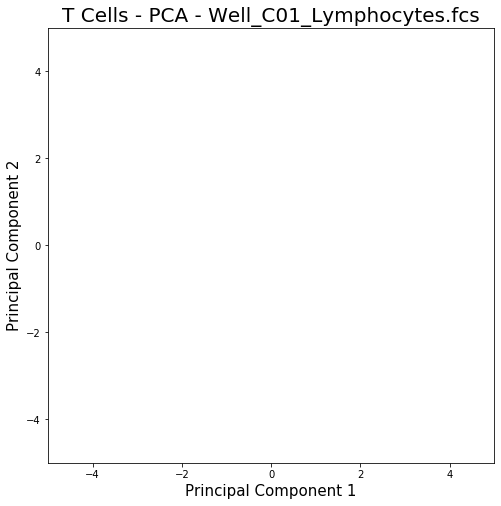

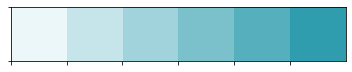

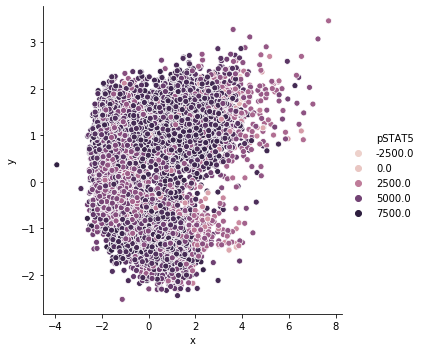

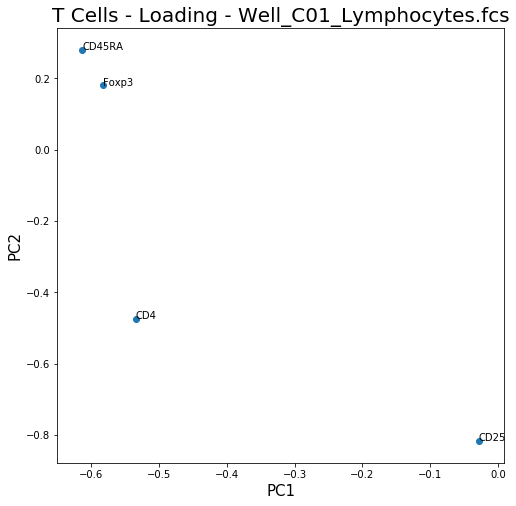

mean pStat activity:  5407.173
[ 0.00722803 -1.5500783  -1.9930173  ...  2.7356076  -1.5203791
 -1.9405544 ]
[-1.2516717   1.0574586   1.4186506  ...  1.3408593   0.5925211
  0.63716304]
[5750.157  3984.1064 6218.2227 ... 6272.2437 5723.608  4731.3643]
[[ 7.2280276e-03 -1.5500783e+00 -1.9930173e+00 ...  2.7356076e+00
  -1.5203791e+00 -1.9405544e+00]
 [-1.2516717e+00  1.0574586e+00  1.4186506e+00 ...  1.3408593e+00
   5.9252107e-01  6.3716304e-01]
 [ 5.7501572e+03  3.9841064e+03  6.2182227e+03 ...  6.2722437e+03
   5.7236079e+03  4.7313643e+03]]
              x         y       pSTAT5
0      0.007228 -1.251672  5750.157227
1     -1.550078  1.057459  3984.106445
2     -1.993017  1.418651  6218.222656
3     -1.013684 -0.260495  4901.901367
4      0.134855 -1.367044  6529.409668
...         ...       ...          ...
14841 -1.682040  1.079134  4363.878906
14842 -0.326369  1.131652  6040.124023
14843  2.735608  1.340859  6272.243652
14844 -1.520379  0.592521  5723.607910
14845 -1.940554  0.6

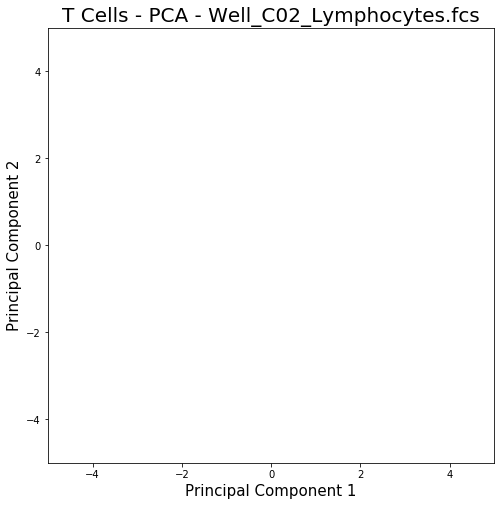

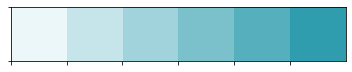

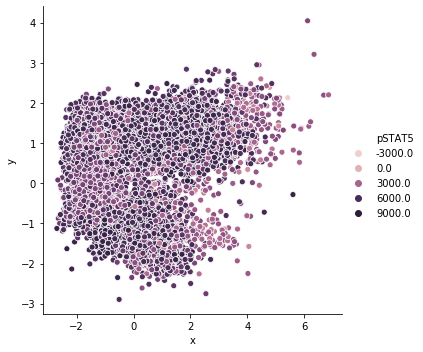

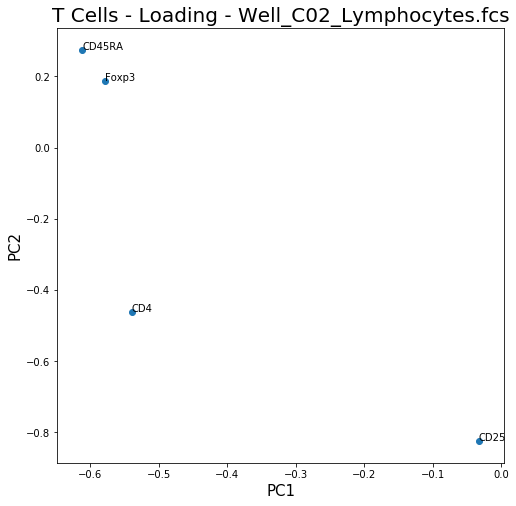

mean pStat activity:  5465.1084
[ 0.347556   3.7085109  2.4948444 ... -1.8075432 -1.5105723 -1.7427584]
[-0.56435865  1.8186376  -1.2867403  ... -0.46766815  1.1217014
 -0.06215612]
[5983.8696 5770.0415 2864.283  ... 4969.2773 4324.643  4703.8833]
[[ 3.4755599e-01  3.7085109e+00  2.4948444e+00 ... -1.8075432e+00
  -1.5105723e+00 -1.7427584e+00]
 [-5.6435865e-01  1.8186376e+00 -1.2867403e+00 ... -4.6766815e-01
   1.1217014e+00 -6.2156122e-02]
 [ 5.9838696e+03  5.7700415e+03  2.8642830e+03 ...  4.9692773e+03
   4.3246431e+03  4.7038833e+03]]
              x         y       pSTAT5
0      0.347556 -0.564359  5983.869629
1      3.708511  1.818638  5770.041504
2      2.494844 -1.286740  2864.282959
3     -0.336978 -0.376656  4676.118652
4      2.776461  0.579594  5416.688477
...         ...       ...          ...
14417  0.533896 -1.373806  6110.479492
14418 -2.139237 -0.480818  4705.428711
14419 -1.807543 -0.467668  4969.277344
14420 -1.510572  1.121701  4324.643066
14421 -1.742758 -0.062156

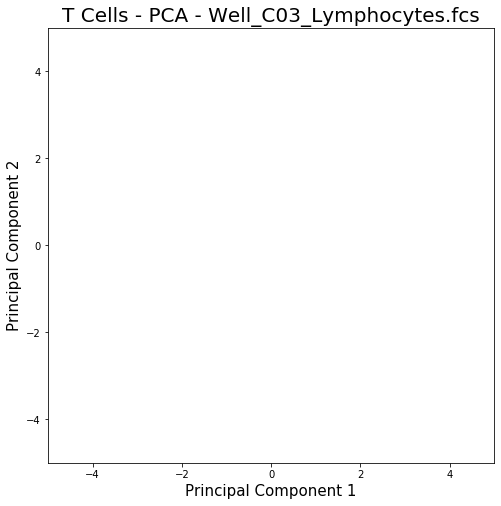

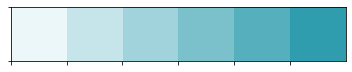

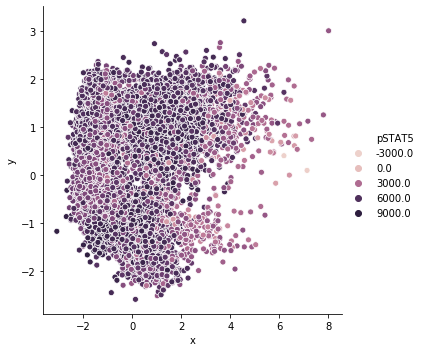

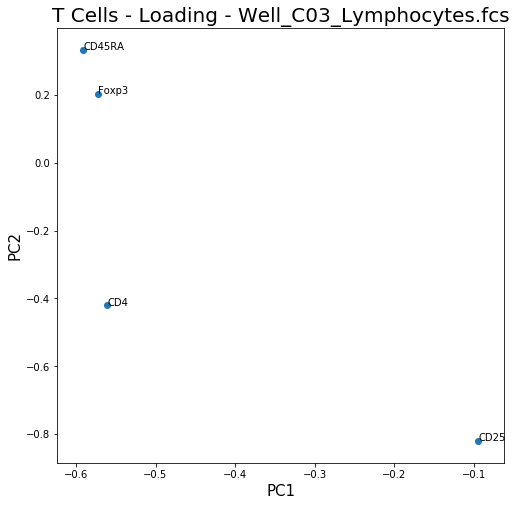

mean pStat activity:  5241.1416
[ 7.849222    0.05909207 -0.3079797  ... -1.1572604  -1.0505549
  3.7881572 ]
[ 0.5499067 -1.6141555 -1.1221726 ...  1.3840518 -0.7149187 -1.6224148]
[ 516.6651 6134.128  5608.7847 ... 4797.58   6413.2183 3813.7913]
[[ 7.8492222e+00  5.9092067e-02 -3.0797970e-01 ... -1.1572604e+00
  -1.0505549e+00  3.7881572e+00]
 [ 5.4990667e-01 -1.6141555e+00 -1.1221726e+00 ...  1.3840518e+00
  -7.1491867e-01 -1.6224148e+00]
 [ 5.1666510e+02  6.1341279e+03  5.6087847e+03 ...  4.7975801e+03
   6.4132183e+03  3.8137913e+03]]
              x         y       pSTAT5
0      7.849222  0.549907   516.665100
1      0.059092 -1.614156  6134.127930
2     -0.307980 -1.122173  5608.784668
3      0.507263 -1.333264  5733.411621
4      2.044497  1.647764  5687.722656
...         ...       ...          ...
15740  1.498419  1.471966  2614.744141
15741 -1.139319  0.269633  4481.582520
15742 -1.157260  1.384052  4797.580078
15743 -1.050555 -0.714919  6413.218262
15744  3.788157 -1.622415

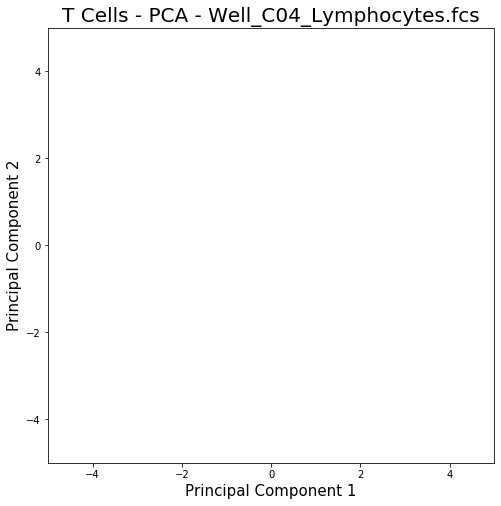

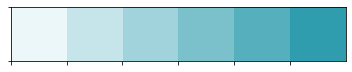

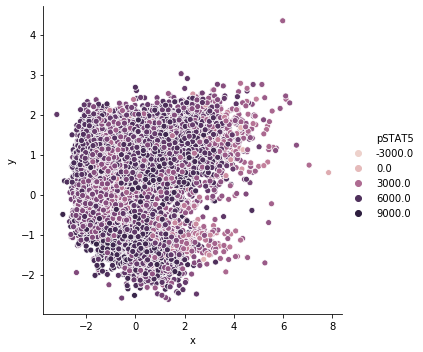

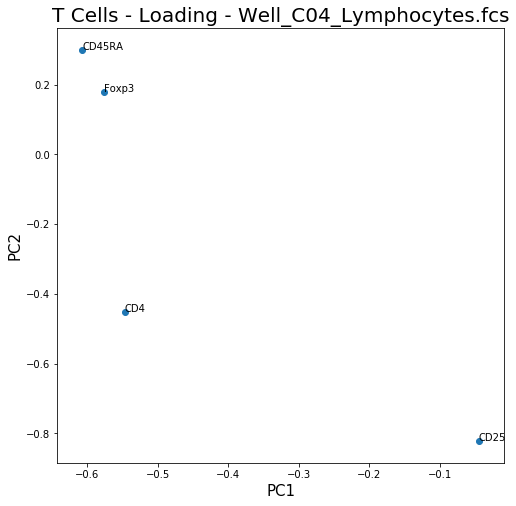

mean pStat activity:  4570.8745
[-0.43787962 -1.2496517   0.68522155 ...  3.0136845   3.4058957
  1.7674644 ]
[-0.64719576  1.5426853  -0.7338237  ... -0.77392405 -1.2913506
 -1.1560165 ]
[3760.948  4160.7583 3677.2556 ... 3204.2224 3933.0413 3041.1116]
[[-4.3787962e-01 -1.2496517e+00  6.8522155e-01 ...  3.0136845e+00
   3.4058957e+00  1.7674644e+00]
 [-6.4719576e-01  1.5426853e+00 -7.3382372e-01 ... -7.7392405e-01
  -1.2913506e+00 -1.1560165e+00]
 [ 3.7609480e+03  4.1607583e+03  3.6772556e+03 ...  3.2042224e+03
   3.9330413e+03  3.0411116e+03]]
              x         y       pSTAT5
0     -0.437880 -0.647196  3760.947998
1     -1.249652  1.542685  4160.758301
2      0.685222 -0.733824  3677.255615
3      0.987279  1.106906  3255.618164
4     -1.581244  0.975944  4378.398438
...         ...       ...          ...
15161  3.181613 -1.025035  2898.091309
15162  2.628396 -0.850388  3131.202637
15163  3.013685 -0.773924  3204.222412
15164  3.405896 -1.291351  3933.041260
15165  1.767464 -1.

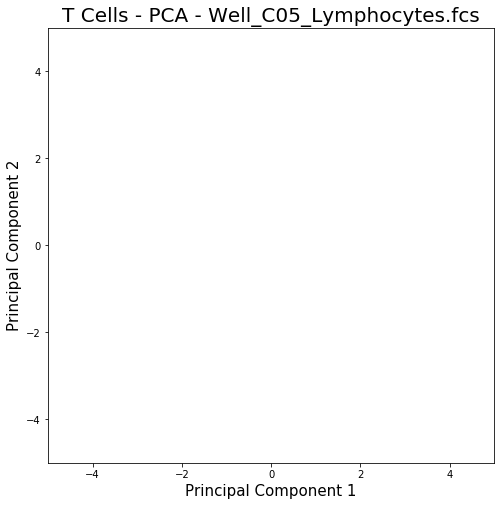

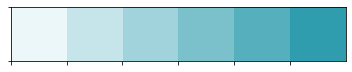

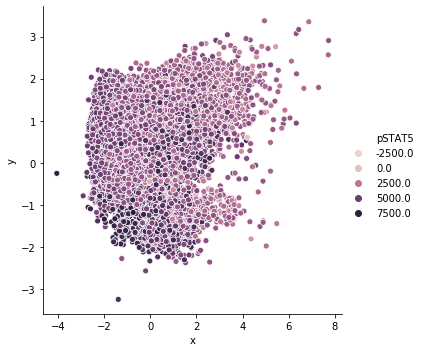

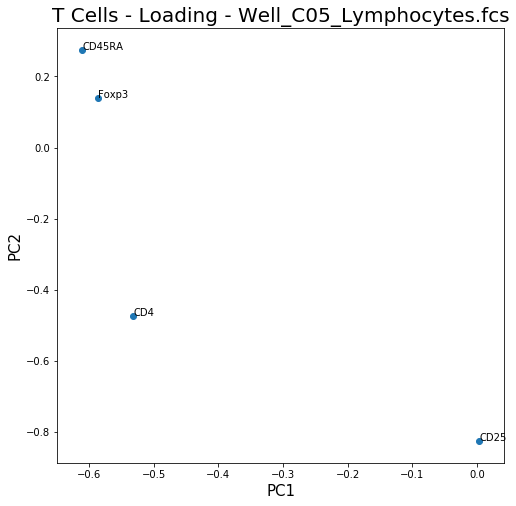

mean pStat activity:  4259.629
[-1.257907    0.17586853  0.29684764 ...  0.49748945 -1.1344959
  0.70503616]
[ 0.3936043  -1.3665987  -1.0687147  ... -0.7844815  -0.6526331
  0.56710684]
[4346.421  5319.09   4478.1763 ... 4644.47   5661.6143 3709.806 ]
[[-1.2579070e+00  1.7586853e-01  2.9684764e-01 ...  4.9748945e-01
  -1.1344959e+00  7.0503616e-01]
 [ 3.9360431e-01 -1.3665987e+00 -1.0687147e+00 ... -7.8448153e-01
  -6.5263307e-01  5.6710684e-01]
 [ 4.3464209e+03  5.3190898e+03  4.4781763e+03 ...  4.6444702e+03
   5.6616143e+03  3.7098059e+03]]
             x         y       pSTAT5
0    -1.257907  0.393604  4346.420898
1     0.175869 -1.366599  5319.089844
2     0.296848 -1.068715  4478.176270
3     0.637988 -0.521611  4201.119629
4     2.076931  1.622930  2809.515869
...        ...       ...          ...
6857  2.839067 -0.098829  4328.898926
6858 -1.653536  0.270871  4512.374023
6859  0.497489 -0.784482  4644.470215
6860 -1.134496 -0.652633  5661.614258
6861  0.705036  0.567107  3709.

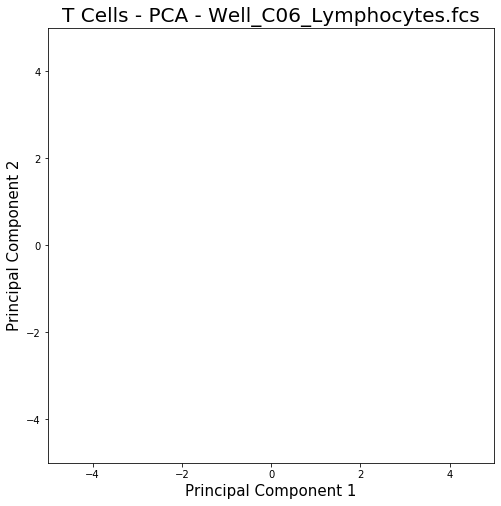

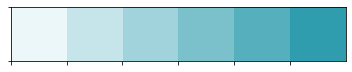

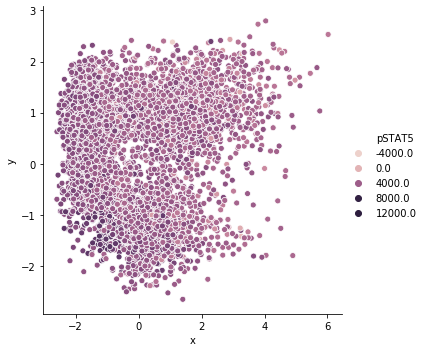

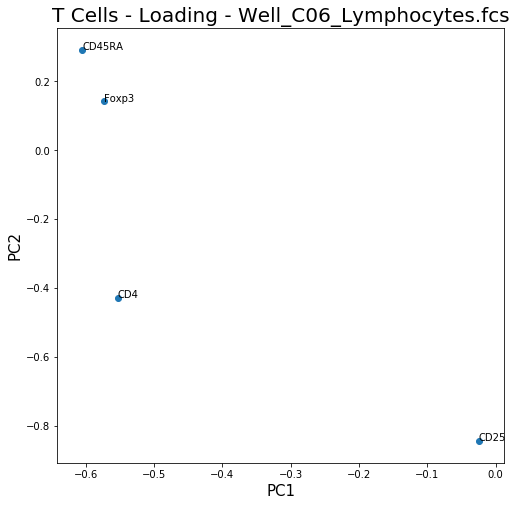

mean pStat activity:  4078.109
[ 7.1552114   0.73540646 -0.9054348  ... -1.2219604  -2.0449276
 -1.1610847 ]
[ 1.6385653  -1.2522578   1.7551014  ...  1.4055585   0.09981541
  1.2246449 ]
[2410.7075 3982.8699 4051.4932 ... 4403.4414 4424.2515 2809.5159]
[[ 7.1552114e+00  7.3540646e-01 -9.0543479e-01 ... -1.2219604e+00
  -2.0449276e+00 -1.1610847e+00]
 [ 1.6385653e+00 -1.2522578e+00  1.7551014e+00 ...  1.4055585e+00
   9.9815406e-02  1.2246449e+00]
 [ 2.4107075e+03  3.9828699e+03  4.0514932e+03 ...  4.4034414e+03
   4.4242515e+03  2.8095159e+03]]
              x         y       pSTAT5
0      7.155211  1.638565  2410.707520
1      0.735406 -1.252258  3982.869873
2     -0.905435  1.755101  4051.493164
3      2.736848 -0.942171  3692.360596
4     -0.993695 -0.077474  3464.584229
...         ...       ...          ...
17144 -1.752100 -0.310285  4556.344727
17145 -0.897828 -0.833687  3071.278320
17146 -1.221960  1.405558  4403.441406
17147 -2.044928  0.099815  4424.251465
17148 -1.161085  1.

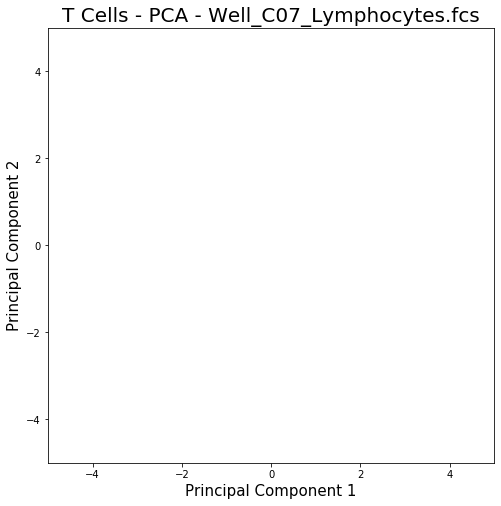

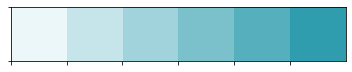

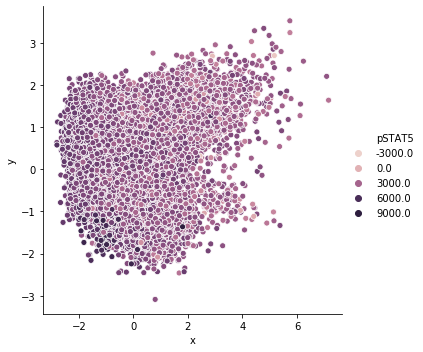

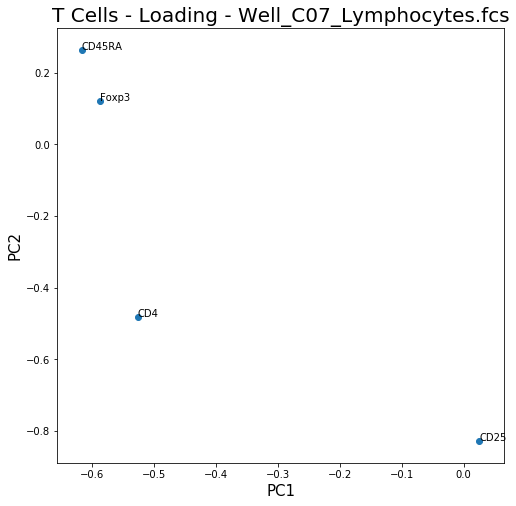

mean pStat activity:  4028.5342
[-2.054485  -1.493638   1.7830205 ...  2.5149055  1.8638799  3.247689 ]
[-0.0237643  -0.6765573   0.3458006  ...  1.1996324   1.3960476
  0.64494514]
[4475.377  4261.7573 2168.001  ... 3993.319  3587.8396 2052.896 ]
[[-2.0544851e+00 -1.4936380e+00  1.7830205e+00 ...  2.5149055e+00
   1.8638799e+00  3.2476890e+00]
 [-2.3764296e-02 -6.7655730e-01  3.4580061e-01 ...  1.1996324e+00
   1.3960476e+00  6.4494514e-01]
 [ 4.4753770e+03  4.2617573e+03  2.1680010e+03 ...  3.9933191e+03
   3.5878396e+03  2.0528960e+03]]
              x         y       pSTAT5
0     -2.054485 -0.023764  4475.376953
1     -1.493638 -0.676557  4261.757324
2      1.783020  0.345801  2168.000977
3      0.672143  1.333943  3438.437988
4      0.153623  1.177510  3827.436279
...         ...       ...          ...
14955  2.027349  0.982948  4104.981934
14956  2.151420  1.073584  3587.839600
14957  2.514905  1.199632  3993.319092
14958  1.863880  1.396048  3587.839600
14959  3.247689  0.644945

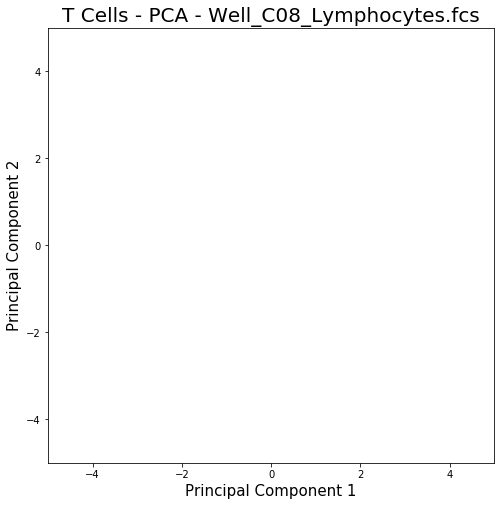

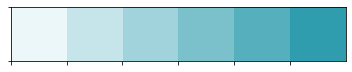

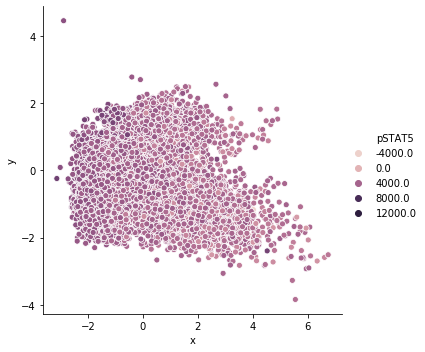

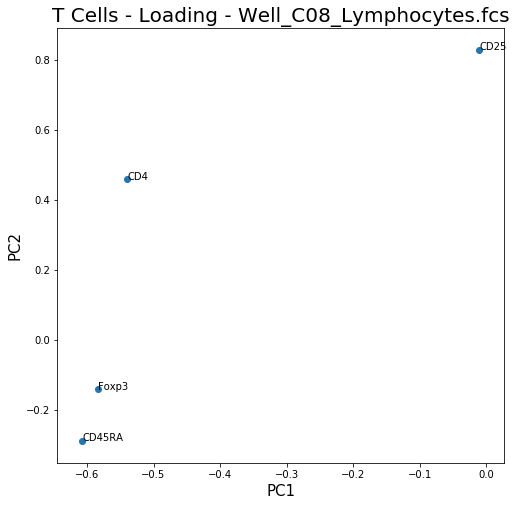

mean pStat activity:  3982.8162
[-0.00946204  0.24454567 -1.2486659  ...  2.0264313   3.5632324
  2.857236  ]
[-1.5339624  -1.1889564  -0.14037578 ... -0.98304963 -0.5692537
 -0.9971005 ]
[2675.1318 3310.072  4652.885  ... 4053.7527 3366.965  3223.9275]
[[-9.4620381e-03  2.4454567e-01 -1.2486659e+00 ...  2.0264313e+00
   3.5632324e+00  2.8572359e+00]
 [-1.5339624e+00 -1.1889564e+00 -1.4037578e-01 ... -9.8304963e-01
  -5.6925368e-01 -9.9710047e-01]
 [ 2.6751318e+03  3.3100720e+03  4.6528848e+03 ...  4.0537527e+03
   3.3669651e+03  3.2239275e+03]]
              x         y       pSTAT5
0     -0.009462 -1.533962  2675.131836
1      0.244546 -1.188956  3310.072021
2     -1.248666 -0.140376  4652.884766
3     -0.271149 -1.193123  4064.949463
4      3.230961  2.803002  2370.709473
...         ...       ...          ...
14397  1.551036 -0.859784  3281.171875
14398  3.065891 -0.665112  2842.580078
14399  2.026431 -0.983050  4053.752686
14400  3.563232 -0.569254  3366.965088
14401  2.857236 -0.

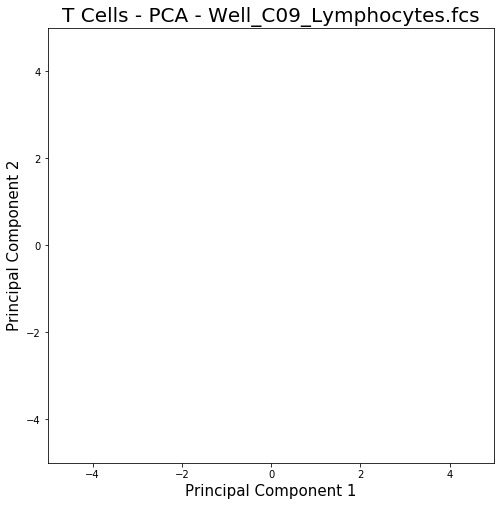

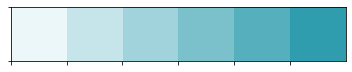

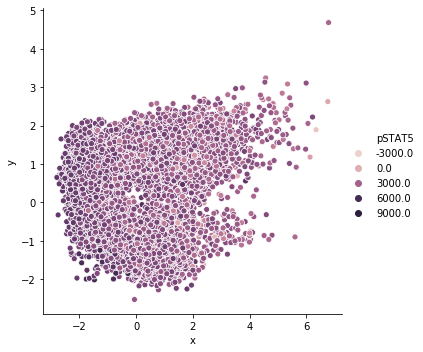

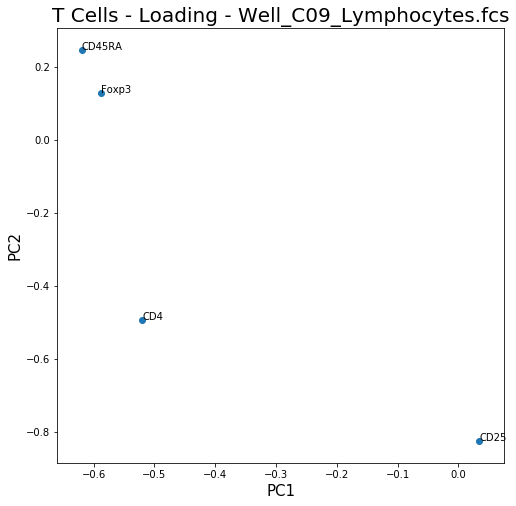

mean pStat activity:  4029.6106
[ 7.1660867  -0.0073334  -1.8273213  ...  0.74968106 -2.611505
 -1.4031211 ]
[ 2.1010325 -1.3388491  1.050892  ... -1.4550672  1.4609884  1.4033765]
[2377.412  4250.207  4402.054  ... 4379.475  4918.2773 4265.1436]
[[ 7.1660867e+00 -7.3333965e-03 -1.8273213e+00 ...  7.4968106e-01
  -2.6115050e+00 -1.4031211e+00]
 [ 2.1010325e+00 -1.3388491e+00  1.0508920e+00 ... -1.4550672e+00
   1.4609884e+00  1.4033765e+00]
 [ 2.3774121e+03  4.2502070e+03  4.4020542e+03 ...  4.3794751e+03
   4.9182773e+03  4.2651436e+03]]
              x         y       pSTAT5
0      7.166087  2.101032  2377.412109
1     -0.007333 -1.338849  4250.207031
2     -1.827321  1.050892  4402.054199
3      1.779542  0.658869  3547.444580
4      0.743476 -1.465878  4252.790039
...         ...       ...          ...
14716 -1.361170  1.430061  5028.053711
14717  2.088429  1.298826  1625.163086
14718  0.749681 -1.455067  4379.475098
14719 -2.611505  1.460988  4918.277344
14720 -1.403121  1.403376 

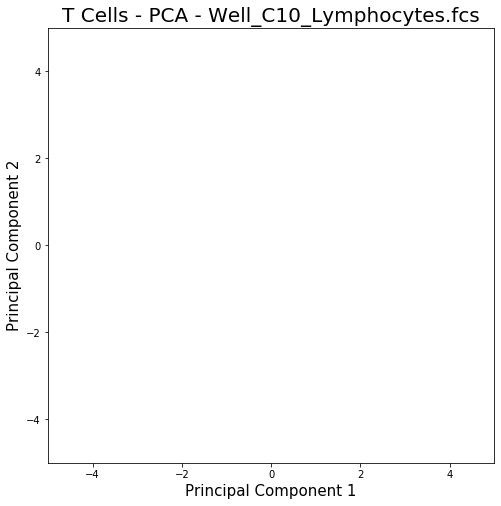

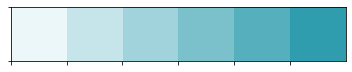

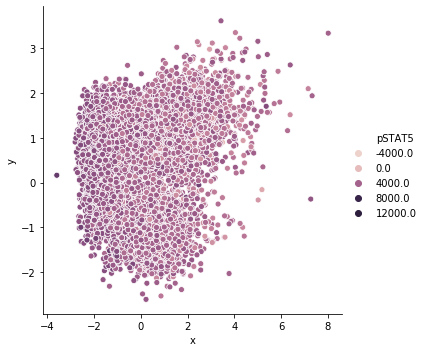

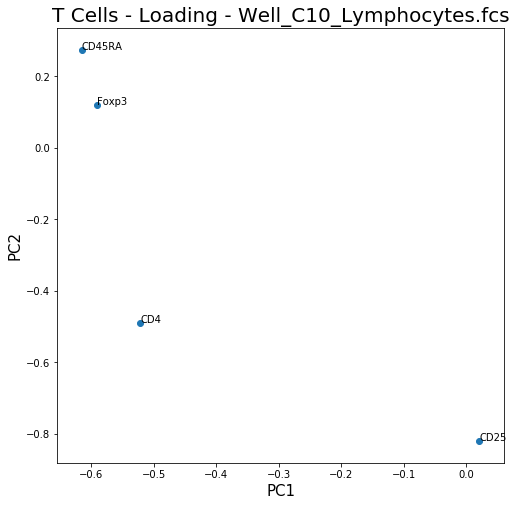

mean pStat activity:  3998.869
[ 0.04163567 -2.7534277   2.1595452  ... -0.971994    0.24217157
  0.7173208 ]
[-1.3931123 -0.5880363  1.016968  ... -0.7513346 -1.1338694 -1.3704413]
[3972.9048 4469.7427 4238.4663 ... 3261.0444 4405.516  4450.294 ]
[[ 4.1635666e-02 -2.7534277e+00  2.1595452e+00 ... -9.7199398e-01
   2.4217157e-01  7.1732080e-01]
 [-1.3931123e+00 -5.8803630e-01  1.0169680e+00 ... -7.5133461e-01
  -1.1338694e+00 -1.3704413e+00]
 [ 3.9729048e+03  4.4697427e+03  4.2384663e+03 ...  3.2610444e+03
   4.4055161e+03  4.4502939e+03]]
              x         y       pSTAT5
0      0.041636 -1.393112  3972.904785
1     -2.753428 -0.588036  4469.742676
2      2.159545  1.016968  4238.466309
3      1.525944 -0.728189  4283.074219
4     -1.012111  0.474009  4368.995605
...         ...       ...          ...
14012 -1.266607 -0.652514  4149.936523
14013  0.404264 -1.282840  3384.078369
14014 -0.971994 -0.751335  3261.044434
14015  0.242172 -1.133869  4405.516113
14016  0.717321 -1.370441

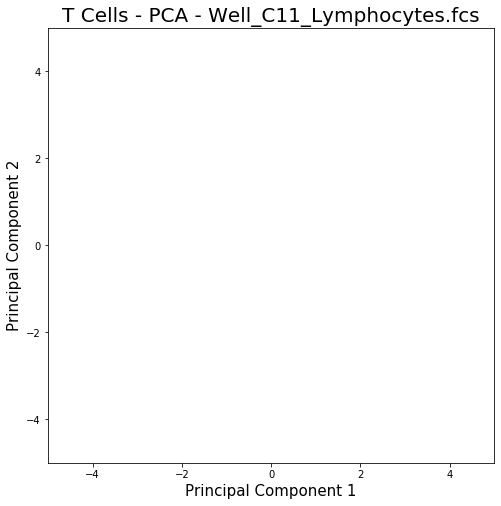

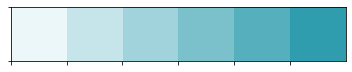

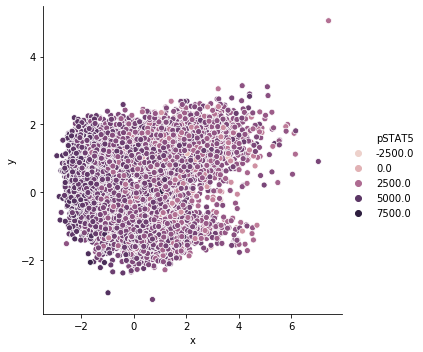

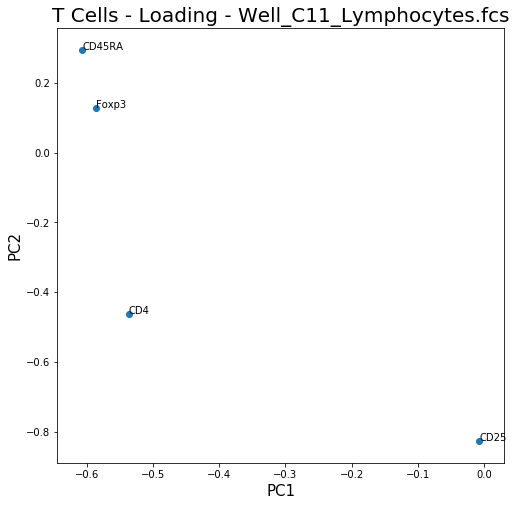

mean pStat activity:  4033.4734
[ 0.18645415  2.3051636   0.8310627  ...  0.56207305  1.3717762
 -0.7748487 ]
[ 0.88687897  0.7161359  -0.9885342  ...  1.196194    0.6662419
 -0.15615724]
[4415.799  4218.009  4123.7046 ... 3016.837  3730.2905 4491.0903]
[[ 1.8645415e-01  2.3051636e+00  8.3106267e-01 ...  5.6207305e-01
   1.3717762e+00 -7.7484870e-01]
 [ 8.8687897e-01  7.1613592e-01 -9.8853421e-01 ...  1.1961941e+00
   6.6624188e-01 -1.5615724e-01]
 [ 4.4157988e+03  4.2180088e+03  4.1237046e+03 ...  3.0168369e+03
   3.7302905e+03  4.4910903e+03]]
              x         y       pSTAT5
0      0.186454  0.886879  4415.798828
1      2.305164  0.716136  4218.008789
2      0.831063 -0.988534  4123.704590
3     -1.210913 -0.587829  4225.637207
4      0.489123 -1.180485  3873.483887
...         ...       ...          ...
13125  0.617157 -0.874852  3075.982666
13126 -0.697399 -1.484795  4032.010742
13127  0.562073  1.196194  3016.836914
13128  1.371776  0.666242  3730.290527
13129 -0.774849 -0.

KeyboardInterrupt: 

In [3]:
tplate = input('What is the name of the T plate folder?:')
tsample, titlesT = importF(tplate)

nkplate = input('What is the name of the NK plate folder?:')
nksample, titlesNK = importF(nkplate)

dataT_array, pstatT_array, xfT_array, loadingT_array = pcaAll(tsample, "t", titlesT)

dataNK_array, pstatNK_array, xfNK_array, loadingNK_array = pcaAll(nksample, "n", titlesNK)
#/home/brianoj/Tplate15